In [64]:
import glob
import importlib
import sys, os

import numpy as np
import scipy.optimize as op

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import astropy.units as u
from itertools import cycle

import emcee
import synphot

from dust_extinction.averages import G03_SMCBar
from dust_extinction.averages import G03_LMCAvg
from dust_extinction.parameter_averages import F19

import measure_extinction
from measure_extinction.stardata import StarData
from measure_extinction.extdata import ExtData
from measure_extinction.modeldata import ModelData
from measure_extinction.utils.fit_model import FitInfo

from measure_extinction.utils.helpers import get_full_starfile
from measure_extinction.utils.fit_model import get_best_fit_params, get_percentile_params

from measure_extinction.plotting.plot_spec import plot_multi_spectra, plot_spectrum
from measure_extinction.merge_obsspec import _wavegrid
from measure_extinction.utils import scale_spex_spec
import extinction_ensemble_props

# Specify the location of the model and observed data
file_path = "/Users/pyanchulova/Documents/extstar_data/"
savefile_path = "/Users/pyanchulova/Documents/ext-science/figs/"
folder = ""

# STIS data location
#karl_data_path = "~/../../user/kgordon/Python_git/extstar_data/STIS_Data/"

if not os.path.isdir(savefile_path + folder):
    print("making new dir", (savefile_path + folder))
    os.system("mkdir " + savefile_path + folder)

galaxy = "m31" #"m33" # "m31"
gal_str = galaxy + "_"

m31_list = [
            # "m31_e1_j004354.05+412626.0",
            # "m31_e2_j004413.84+414903.9","m31_e3_j004420.52+411751.1",
            # "m31_e4_j004427.47+415150.0","m31_e5_j004431.66+413612.4",
            # "m31_e6_j004438.71+415553.5", #bad photometry?
            # "m31_e7_j004454.37+412823.9","m31_e8_j004511.82+415025.3","m31_e9_j004511.85+413712.9", 
            # "m31_e10_j004512.73+413726.4", "m31_e11_j004535.40+414431.5", # No STIS data
            # "m31_e12_j004539.00+415439.0","m31_e13_j004539.70+415054.8",
            # "m31_e14_j004543.46+414513.6",
            # "m31_e15_j004546.81+415431.7",
            "m31_e17_j003944.71+402056.2",
            # "m31_e18_j003958.22+402329.0",
            "m31_e22_j004034.61+404326.1",
            "m31_e24_j004412.17+413324.2",
            ]
m33_list = ["m33_e1_j013334.26+303327", 
            "m33_e2_j013339.52+304540",
            #"m33_e3_j013250.80+303507", 
            "m33_e4_j013344.59+304436", 
            #"m33_e5_j013406.63+304147", 
            #"m33_e6_j013410.59+304616", 
            "m33_e7_j012241.93+304728", 
            #"m33_e8_j013416.10+303344.9"
           ]

relband = "WFPC2_F439W" #"ACS_F475W"
relband_str = "$F439W$" #"$F475W$"

if galaxy == 'm33':
    velocity = -179.2 # M33 radial velocity from NED
    m31_list = m33_list
else:
    velocity = -109.3 # M31 radial velocity from NED


# to test aquisition of fstarname
starname = m31_list[0]
fstarname = f"{starname}.dat"

starstr = starname.split(gal_str)[1].split("_")[0]
print("starname and starstr", starname, starstr)
fontsize=14

print("stars list:", m31_list)
print("gal_str:", gal_str)

# Read in the star data
def get_red_star(fstarname, file_path, excl_zero=True, excl_wls=False, rebin=True, rbres=750):
    """
    Sample call: red_star, band_names, data_names = get_red_star(fstarname, file_path)
    
    excl_wls:   list. default=False
                    exclude data in the range given by excl_wls (170-200 nm for some stars)
    """
    # get the observed reddened star data
    reddened_star = StarData(fstarname, path=f"{file_path}/DAT_files/")
    
    # Turn zeros into NaNs
    if excl_zero:
        for curtype in reddened_star.data.keys():
            reddened_star.data[curtype].fluxes[reddened_star.data[curtype].npts == 0] = np.nan
            
    if excl_wls:
        for curtype in reddened_star.data.keys():
            (gindxs,) = np.where(
                (reddened_star.data[curtype].waves.to(u.micron).value >= excl_wls[0])
                & (reddened_star.data[curtype].waves.to(u.micron).value <= excl_wls[1])
            )
            reddened_star.data[curtype].fluxes[gindxs] = np.nan
    else:
        gindxs=None
    
    # Implement rebinning here eventually
#     if rebin:
#         print("Rebinning spectra to {} res".format(rbres))
#         gres = 750
#         rwaverange = [0.11, 0.32] * u.micron
#         reddened_star.data["STIS"].rebin_constres(rwaverange, gres)

    band_names = reddened_star.data["BAND"].get_band_names()
    data_names = reddened_star.data.keys()

    return reddened_star, band_names, data_names

starname and starstr m31_e17_j003944.71+402056.2 e17
stars list: ['m31_e17_j003944.71+402056.2', 'm31_e22_j004034.61+404326.1', 'm31_e24_j004412.17+413324.2']
gal_str: m31_


In [58]:
fontsize = 18
font = {"size": fontsize}
plt.rc("font", **font)

### Read in models (choose rebinned or not)

In [3]:
rebin=True
rwaverange=None
gres=None
if rebin:
    rwaverange = [0.1, 0.32] * u.micron
    gres = 150

tlusty_models_fullpath = glob.glob("{}/Models/tlusty_*v10.dat".format(file_path))
tlusty_models = [
    tfile[tfile.rfind("/") + 1 : len(tfile)] for tfile in tlusty_models_fullpath
]

# run line just to get band names and spectra needed for ModelData
red_star, band_names, data_names = get_red_star(fstarname, file_path)

modinfo_rb = ModelData(
    tlusty_models,
    path="{}/Models/".format(file_path),
    band_names=band_names,
    spectra_names=data_names,
    rebin=rebin,
    waverange=rwaverange,
    resolution=gres
)

### (optional) Test plot model rebin

In [61]:
plot_non_rb = True

# Also plot non-rebinned model for comparison
if plot_non_rb:
    modinfo_not_rb = ModelData(
    tlusty_models,
    path="{}/Models/".format(file_path),
    band_names=band_names,
    spectra_names=data_names,
    )

/Users/pyanchulova/Documents/ext-science/measure_extinction/stardata.py:429: UserWarning: cannot get flux for WFPC2_F255W
  warnings.warn("cannot get flux for %s" % band_name, UserWarning)


TypeError: 'NoneType' object is not subscriptable

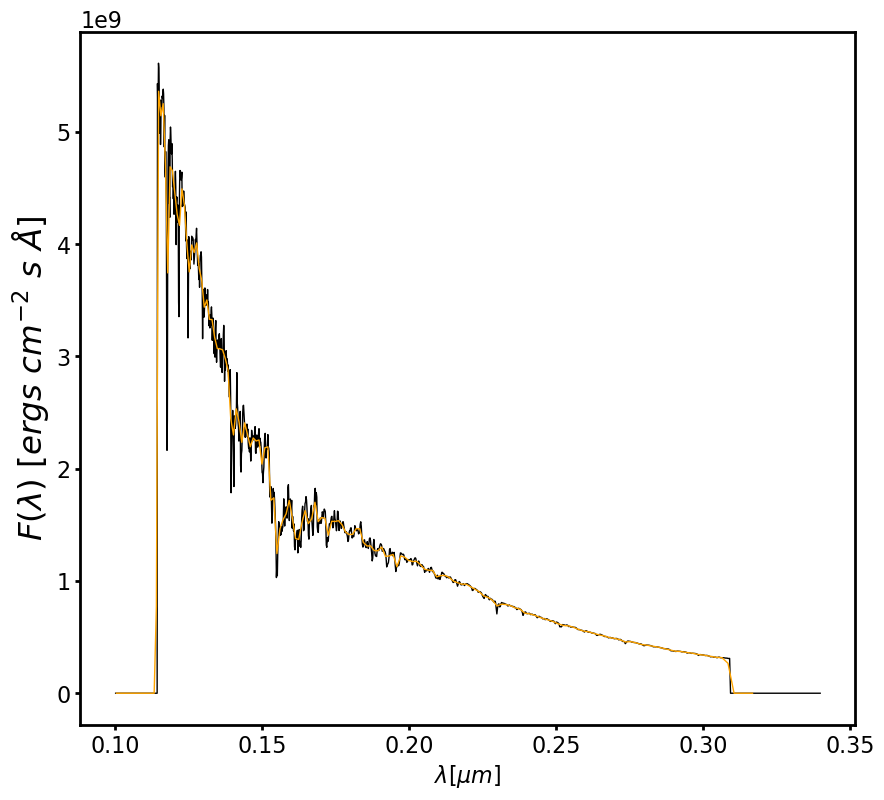

In [46]:
fig, ax = plt.subplots(figsize=(10, 9))
spec_n=410

for i in range(1):
    if plot_non_rb:
        ax.plot(
            modinfo_not_rb.waves["STIS"], 
            modinfo_not_rb.fluxes["STIS"][spec_n], c='k')
    ax.plot(
        modinfo_rb.waves["STIS"], 
        modinfo_rb.fluxes["STIS"][spec_n], c='orange'
        )
ax.set_xlabel("$\lambda [\mu m]$")
ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
plt.savefig(savefile_path + "/mod_spec_gres_" + str(gres) + ".pdf")

### (optional) Limit list

In [62]:
# m31_list=m31_list[-5:]
print (m31_list)

['m31_e17_j003944.71+402056.2', 'm31_e22_j004034.61+404326.1', 'm31_e24_j004412.17+413324.2']


### (optional) Test exclusion of zero-flux data & exclusion of data in certain WL range

nan erg / (Angstrom cm2 s)
0.10005006194114685 micron
0.17 7.947730790515189e-16 erg / (Angstrom cm2 s)
[<Quantity 0.17 micron>, <Quantity 0.2 micron>]
nan erg / (Angstrom cm2 s)
0.10005005674209207 micron
0.17 3.2269e-16 erg / (Angstrom cm2 s)
[<Quantity 0.17 micron>, <Quantity 0.2 micron>]
nan erg / (Angstrom cm2 s)
0.10005005674209207 micron
0.17 4.2795e-16 erg / (Angstrom cm2 s)
[<Quantity 0.17 micron>, <Quantity 0.2 micron>]


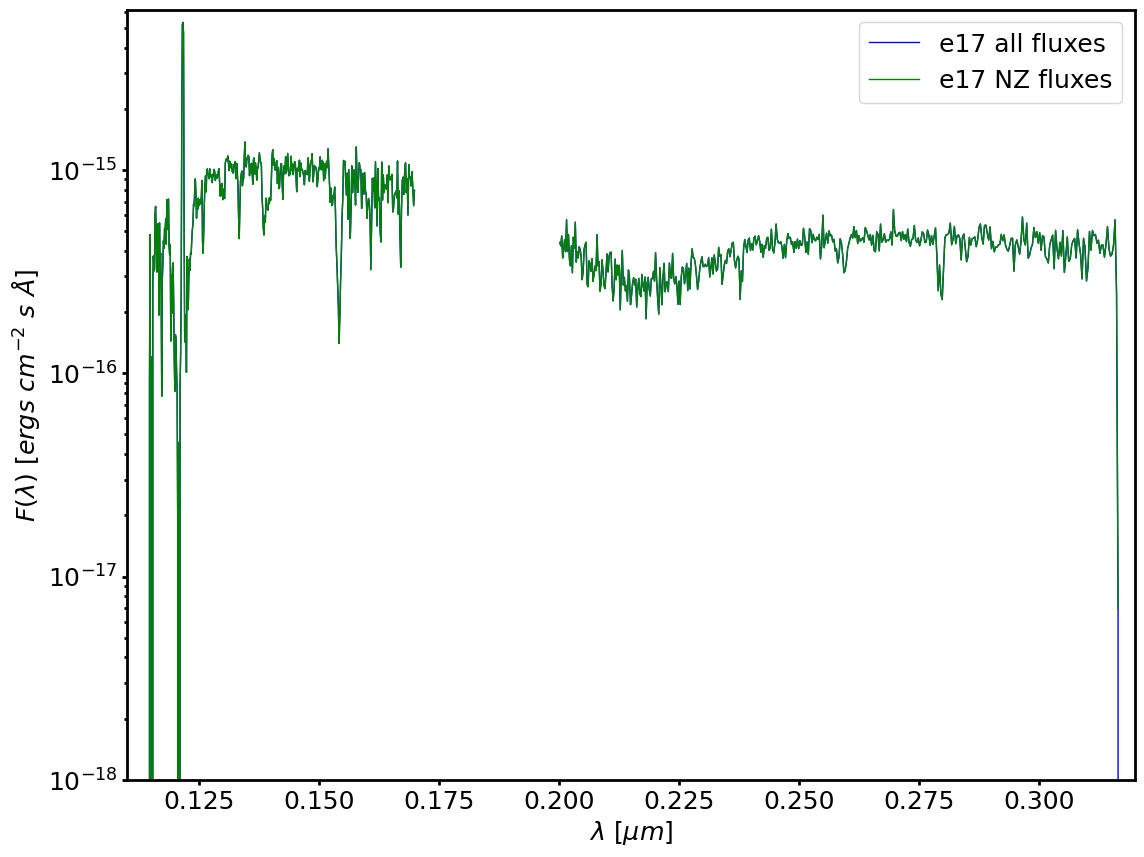

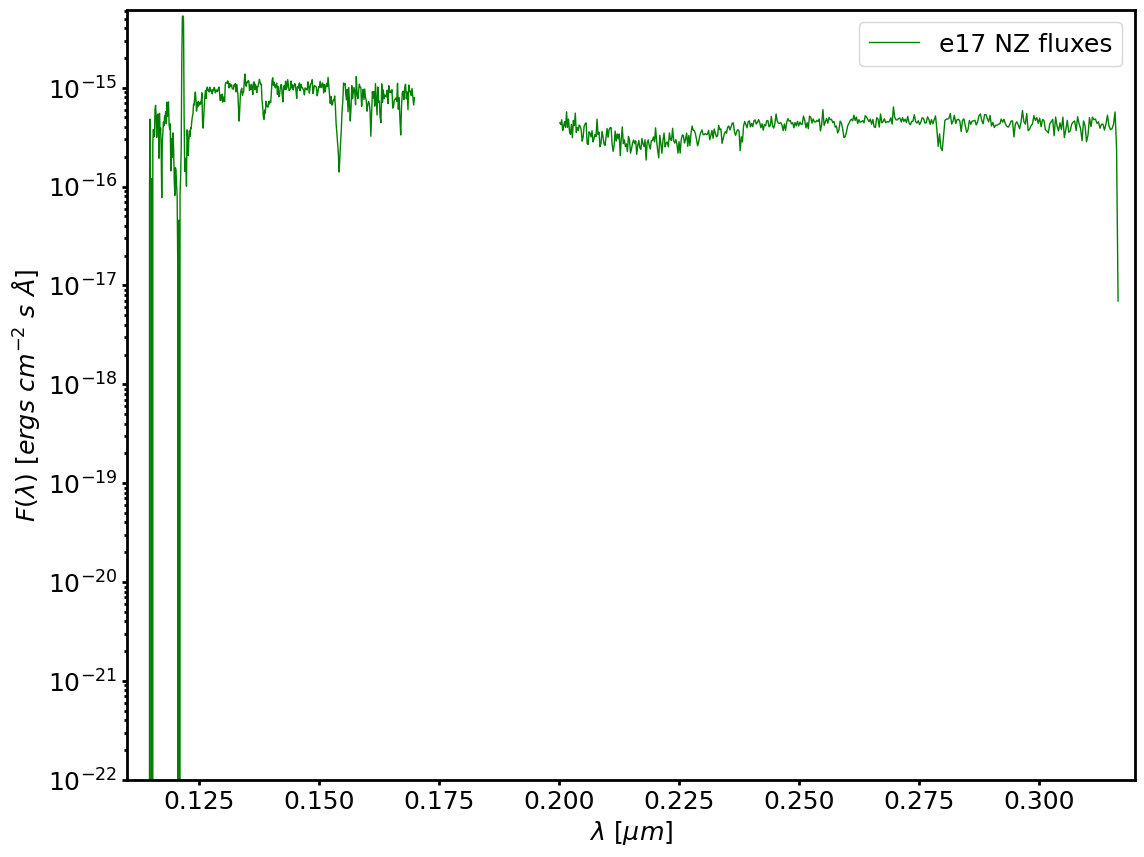

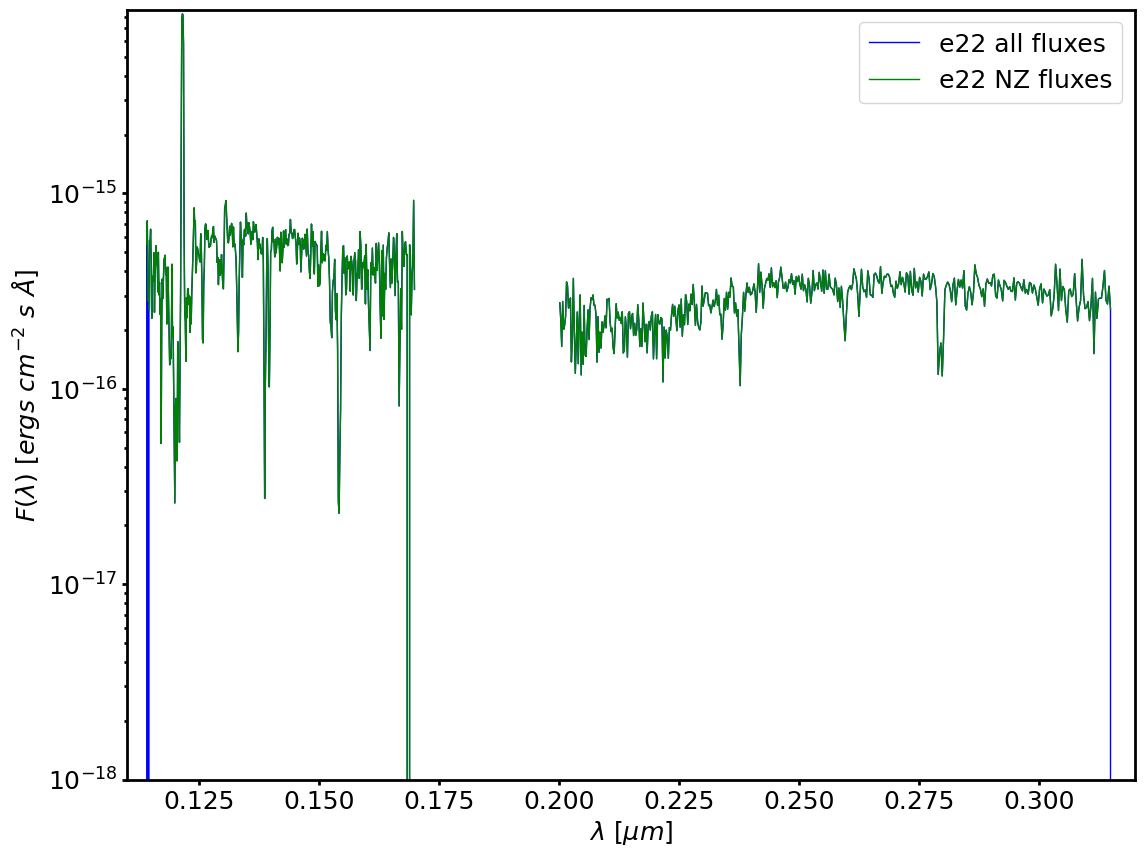

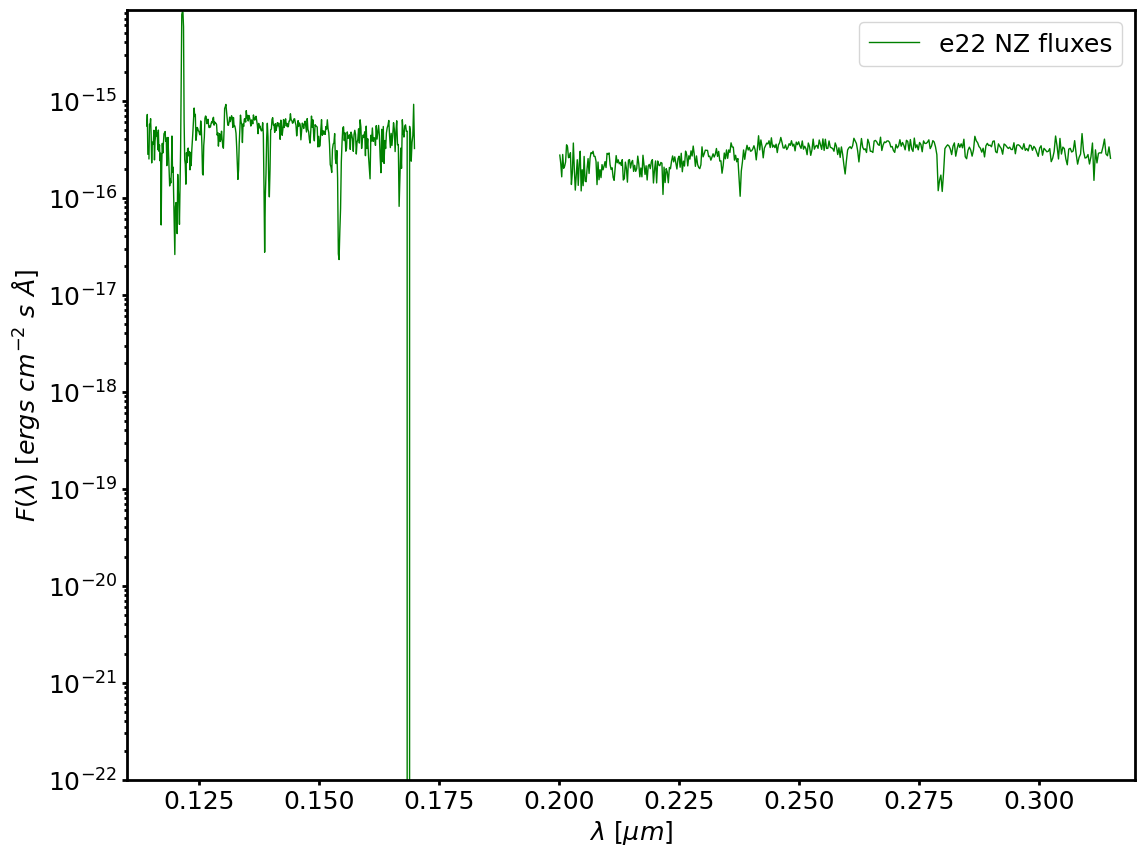

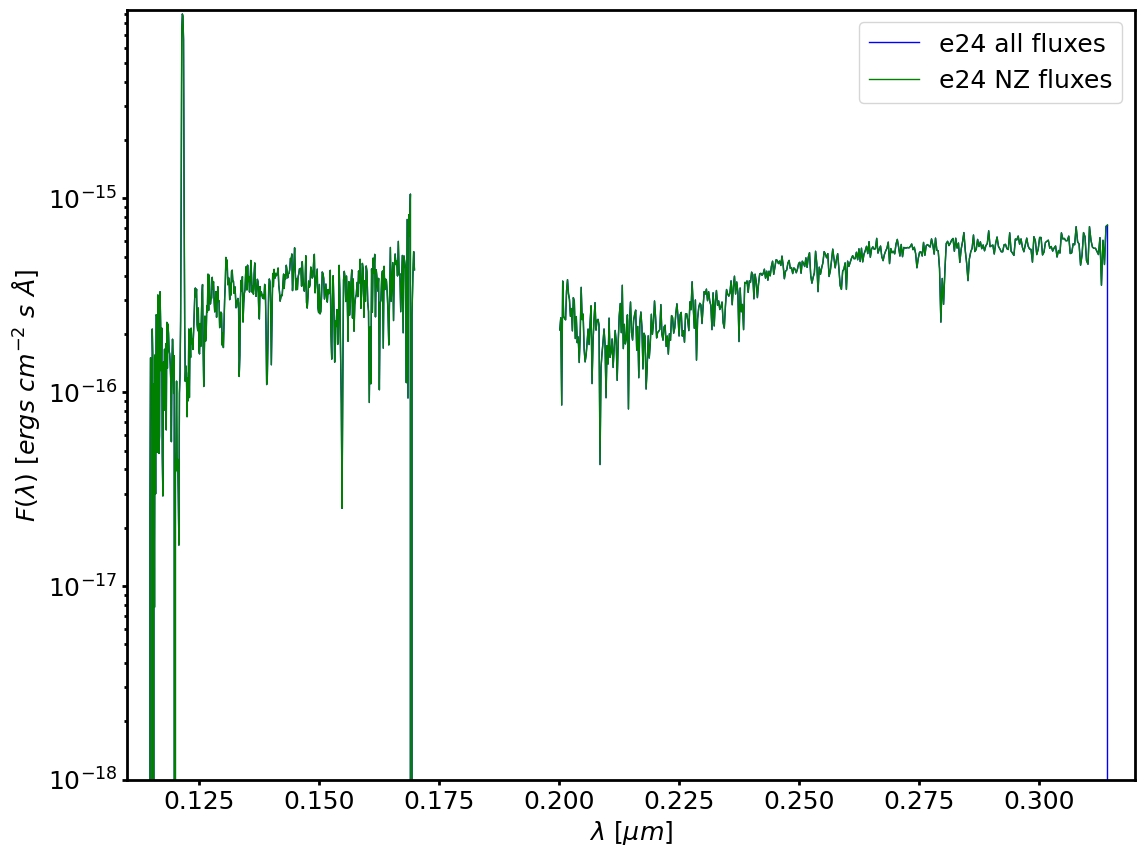

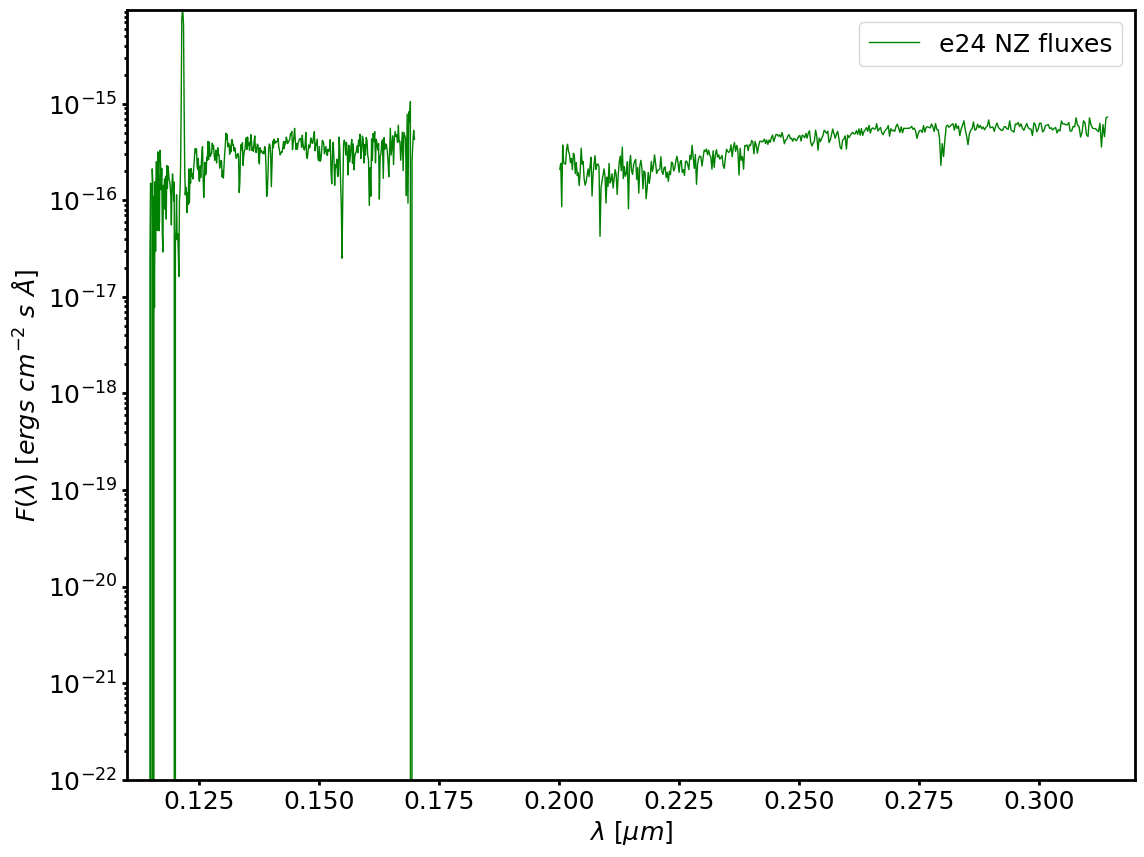

In [69]:
# m31_list = ["m31_e1_j004354.05+412626.0",
#             "m31_e6_j004438.71+415553.5",
#             "m31_e14_j004543.46+414513.6",
#             ]
excl_wls = [.17, .2] # wavelength range to exclude, in microns

for i in range(len(m31_list)):
    starname = m31_list[i]
    fstarname = f"{starname}.dat"
    path = f"{file_path}/DAT_files/"
    starstr = starname.split(gal_str)[1].split("_")[0]

    # Get star data, WITHOUT excluding zero flux
    # gindxs are flux indices of exclided WL range
    excl_wls = [.17, .2]
    red_star_a, band_names_a, data_names_a = get_red_star(fstarname, file_path, excl_zero=False, excl_wls=excl_wls)
    norm_data_a = np.average(red_star_a.data["BAND"].fluxes)

    # Get star data, with only non-zero flux
    # gindxs are flux indices of exclided WL range
    red_star_nz, band_names_nz, data_names_nz = get_red_star(fstarname, file_path, excl_zero=True, excl_wls=excl_wls)
    norm_data_nz = np.average(red_star_nz.data["BAND"].fluxes)

    norm_flux_a = red_star_a.data["STIS"].fluxes / norm_data_a
    norm_flux_nz = red_star_nz.data["STIS"].fluxes / norm_data_nz

    # Plot spectra, both with and w/o zero fluxes
    fig, ax = plt.subplots(figsize=(13, 10))
    ax.plot(red_star_a.data["STIS"].waves, red_star_a.data["STIS"].fluxes, "b-", label=starstr + " all fluxes")
    ax.plot(red_star_nz.data["STIS"].waves, red_star_nz.data["STIS"].fluxes, "g-", label=starstr + " NZ fluxes")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    ax.set_xlim(0.11,0.32)
    ylim = ax.get_ylim()
    ax.set_ylim(1e-18, ylim[1]) # 1e-22
    ax.set_yscale("log")
    plt.legend()
    plt.savefig(savefile_path + "non_zero_flux_spectra_" + gal_str.split("_")[0] + "/" + starstr + "both_yaxis_t3.pdf")

    # Plot only non-zero fluxes
    fig, ax = plt.subplots(figsize=(13, 10))
    # ax.plot(red_star_a.data["STIS"].waves, red_star_a.data["STIS"].fluxes, "b-")
    print(red_star_nz.data["STIS"].fluxes[0])
    print(red_star_nz.data["STIS"].waves[0])
    ax.plot(red_star_nz.data["STIS"].waves, red_star_nz.data["STIS"].fluxes, "g-", label=starstr + " NZ fluxes")
    # plot excluded data as a dashed line
    if excl_wls:
        # print("gindxs[0]-1", gindxs[0]-1)
        excl_flux_range = [red_star_nz.data["STIS"].fluxes[gindxs[0]-1], red_star_nz.data["STIS"].fluxes[gindxs[1]+1]]
        print(excl_wls[0], excl_flux_range[0])
        excl_wls_mic = [x * u.micron for x in excl_wls]
        print(excl_wls_mic)
        # ax.plot(excl_wls_mic, excl_flux_range, ls="--", c='gray', label=starstr + " excl fluxes")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    ax.set_xlim(0.11,0.32)
    ylim = ax.get_ylim()
    ax.set_ylim(1e-22, ylim[1])
    ax.set_yscale("log")
    plt.legend()
    plt.savefig(savefile_path + "non_zero_flux_spectra_" + gal_str.split("_")[0] + "/" + 
                starstr + "nz_t7.pdf")

### Calculate spectra - photometry scaling factor

In [4]:
# various options

for i in range(len(m31_list)):
    starname = m31_list[i]
    fstarname = f"{starname}.dat"
    path = f"{file_path}/DAT_files/"
    starstr = starname.split(gal_str)[1].split("_")[0]
    
    # Calculate spectra correction scaling factor after comparing photometry 
    # obtained from spectra with the band photometry
    reddened_star = StarData(fstarname, path=path)
    print(reddened_star.data.keys())
    # corfac = scale_spex_spec.calc_save_corfac_spex(starname, path=f"{file_path}/DAT_files/")



dict_keys(['BAND', 'STIS'])
dict_keys(['BAND', 'STIS'])
dict_keys(['BAND', 'STIS'])
dict_keys(['BAND', 'STIS'])
dict_keys(['BAND', 'STIS'])
dict_keys(['BAND', 'STIS'])
dict_keys(['BAND', 'STIS'])
dict_keys(['BAND', 'STIS'])
dict_keys(['BAND', 'STIS'])
dict_keys(['BAND', 'STIS'])
dict_keys(['BAND', 'STIS'])
dict_keys(['BAND'])
dict_keys(['BAND', 'STIS'])
dict_keys(['BAND', 'STIS'])
dict_keys(['BAND', 'STIS'])


/Users/pyanchulova/Documents/ext-science/measure_extinction/stardata.py:1059: UserWarning: /Users/pyanchulova/Documents/extstar_data//DAT_files/STIS_Data/j003944.71+402056.2_stis_UV.fits does not exist
  warnings.warn(f"{fname} does not exist", UserWarning)


### (optional) Plot rebinned spectra + find spec-phot corr factor (measure_extinction)

In [14]:
m31_list

'm31_e17_j003944.71+402056.2'

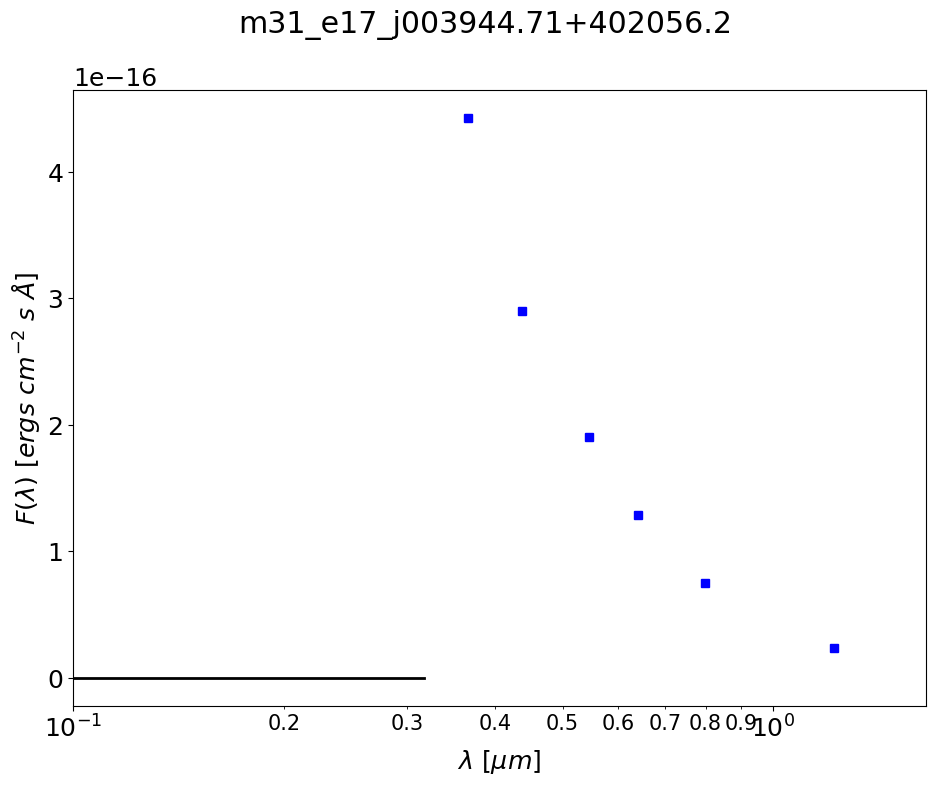

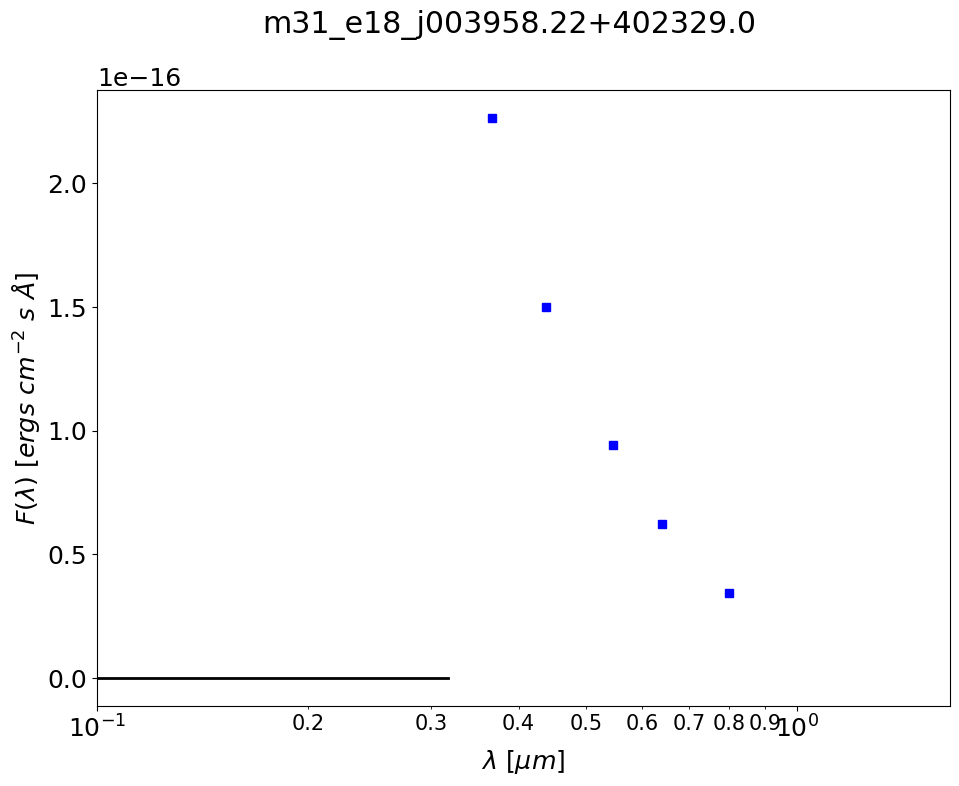

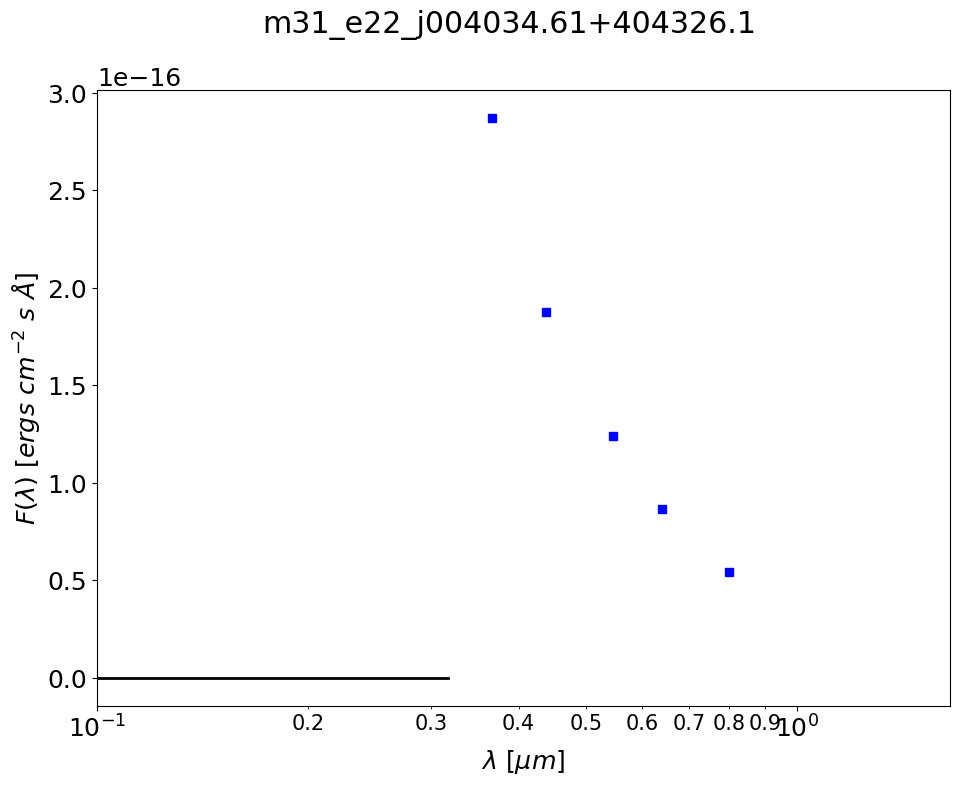

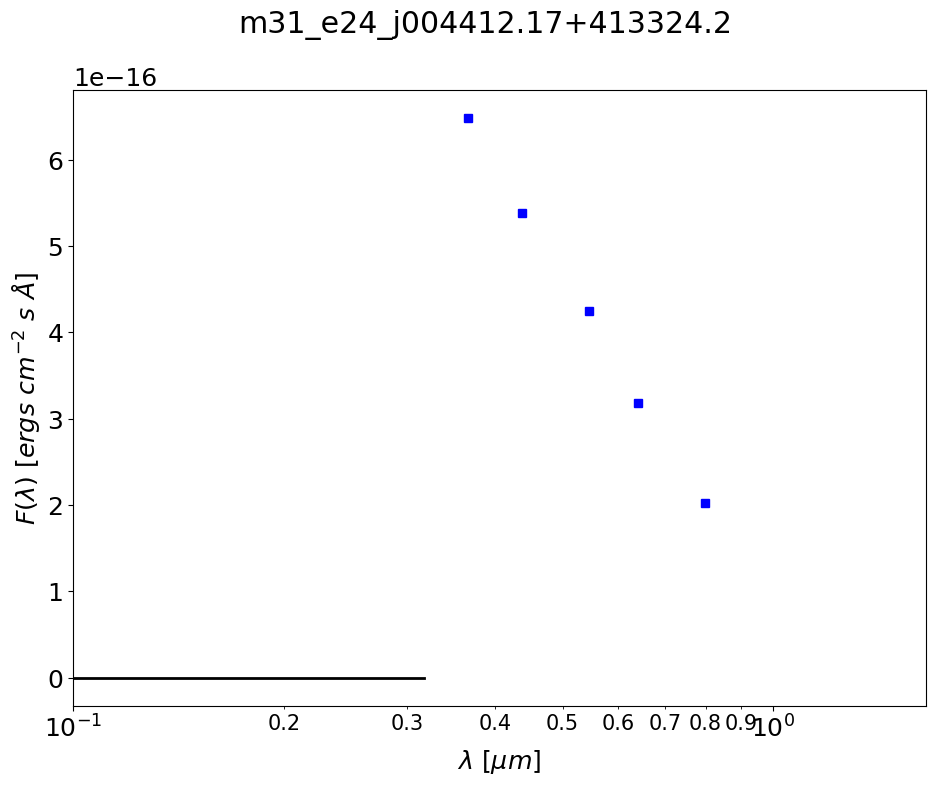

In [25]:
# Rebin params
# Tested resolutions: 125, 250, 500, 750; Data ~= 1000; > Data: 1250, 1500, 2000
rwaverange = [0.1, 0.32] * u.micron
gres = 150
plot_zoomed = False
plot_norm = False
plot_non_rebinned = False
plot_orig_res_data=False # Do we want to plot the unrebinned spectra
# m31_list=m31_list[0]

for i in range(len(m31_list)):
    starname = m31_list[i]
    fstarname = f"{starname}.dat"
    path = f"{file_path}/DAT_files/"
    starstr = starname.split(gal_str)[1].split("_")[0]

    # default settings
    #plot_spectrum(starname, path)

    # Get star data; default removes zero-flux data
    red_star, band_names, data_names = get_red_star(fstarname, file_path)
    norm_data = np.average(red_star.data["BAND"].fluxes)

    # ================== UV spectra WL range only ==============
    if plot_zoomed:
        fig, (ax,ax2) = plt.subplots(2, 1, figsize=(11, 12))
    else:
        plt.figure(figsize=(11, 8))
        ax = plt.gca()
        
    # plot the bands and all spectra for this star
    for cspec in data_names:
        ptype = "-"
        
        if cspec == "BAND":
            ptype = "s"
            label=""

        norm_flux = red_star.data[cspec].fluxes / norm_data
        if plot_norm:
            not_rb_data = norm_flux
        else:
            not_rb_data = red_star.data[cspec].fluxes
            
        if cspec == "BAND":
            clr="b" #"b"
        else:
            clr="k"

        # Plot default observations, not rebinned:
        if plot_orig_res_data:
            if cspec == "STIS":
                ax.plot(
                    red_star.data[cspec].waves,
                    not_rb_data,
                    clr + ptype,
                    label=label,
                    lw=1,
                    zorder=1
                    )            
        
        # REBIN an instance of the STIS spectra; does not rebin the original instance
        if cspec == "STIS":
            spec_rb = red_star.data[cspec]
            spec_rb.rebin_constres(rwaverange, gres)
            
        #     reddened_star, band_names, data_names = get_red_star(fstarname, file_path)

        #     # Remove negative fluxes
        #     nvals = reddened_star.data["STIS"].fluxes < 0
        #     reddened_star.data["STIS"].npts[nvals] = 0

        #     # Rebin spectra
        #     reddened_star.data["STIS"].rebin_constres(rwaverange, gres)

            rb_data = spec_rb.fluxes

            # Adjust spectra if offset from photometry
            rb_data_adj = rb_data.value # no adjustment

            # spec_rb.rebin_constres(rwaverange, gres)
            # rb_data = spec_rb.fluxes
            # rb_data_adj = rb_data.value
            # reddened_star.data["STIS"].rebin_constres(rwaverange, gres)
            
            
            # ========================= Adjust spectra ===================
            spec_adj = spec_corr(galaxy, starstr)
            rb_data_adj = rb_data.value * spec_adj 
       
            # Plot rebinned and adjusted spectra
            ax.plot(
                spec_rb.waves,
                rb_data_adj,
                "k" + ptype, #"g"
                label="RB data:{}".format(gres) ,
                lw=2,#3
                zorder=2
            )
            
#             ax.plot(
#                 red_star.data[cspec].waves,
#                 red_star.data[cspec].fluxes,#norm_flux,
#                 "k" + ptype,
#                 label=label,)

        # Plot photometry on top
        if cspec == "BAND":
            ax.plot(
                red_star.data[cspec].waves,
                not_rb_data,
                clr + ptype,
                zorder=3)                    

        ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
        ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA]$", fontsize=1.3 * fontsize)

        # Set y-axis limits based on flux
        if 'm31' in gal_str:
            if starstr == 'e1':
                ax.set_ylim(-0.1e-15, 0.4e-15)
            if starstr == 'e2':
                ax.set_ylim(-0.04e-15, 1.1e-15)
            if starstr == 'e3':
                ax.set_ylim(-0.015e-15, 1.0e-15)
            if starstr == 'e4':
                ax.set_ylim(-0.15e-15, 0.4e-15)
            if starstr == 'e5':
                ax.set_ylim(-0.1e-15, 1.25e-15)
            if starstr == 'e6':
                ax.set_ylim(0.e-14, 2.3e-15)
            if starstr == 'e7':
                ax.set_ylim(-0.2e-15, 0.5e-15)
            if starstr == 'e8':
                ax.set_ylim(-0.2e-15, 0.8e-15)
            if starstr == 'e9':
                ax.set_ylim(-0.1e-15, 1e-15)
            if starstr == 'e12':
                ax.set_ylim(-0.2e-15, 0.05e-14)
            if starstr == 'e13':
                ax.set_ylim(-0.2e-15, 0.5e-15)
            if starstr == 'e14':
                ax.set_ylim(-0.11e-15, 0.4e-15)
            if starstr == 'e15':
                ax.set_ylim(-0.1e-15, 0.6e-15)
  
        elif 'm33' in gal_str:
            if starstr == 'e1':
                ax.set_ylim(-0.05e-15, 0.5e-15)
            if starstr == 'e2':
                ax.set_ylim(-0.05e-15, 0.7e-15)
            if starstr == 'e3':
                ax.set_ylim(-0.1e-15, 0.6e-15)
            if starstr == 'e4':
                # ax.set_ylim(-0.05e-15, 2.e-15)
                ax.set_ylim(-0.05e-15, 1.15e-15)
            if starstr == 'e6':
                ax.set_ylim(-0.1e-15, 0.4e-15)
            if starstr == 'e7':
                # ax.set_ylim(-0.1e-15, 0.85e-15)
                ax.set_ylim(-0.1e-15, 0.5e-15)
            if starstr == 'e8':
                ax.set_ylim(-0.1e-15, 0.3e-14)
    
        xl = (0.1, 1.65)
        ax.set_xlim(xl)
        ax.set_xscale('log')
        
        plt.tick_params(axis='both', which='minor', labelsize=15)
        ax.yaxis.set_minor_formatter(ticker.FormatStrFormatter("%.1f"))
        ax.xaxis.set_minor_formatter(ticker.FormatStrFormatter("%.1f"))
        ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=20))


    # ============ Zoomed plot ==================
    if plot_zoomed:
        red_star, band_names, data_names = get_red_star(fstarname, file_path)

        for cspec in data_names:

            # zoomed plot
            norm_flux = red_star.data[cspec].fluxes / norm_data
            ax2.plot(
                red_star.data[cspec].waves,
                red_star.data[cspec].fluxes,#norm_flux,
                "k" + ptype,
            )
            if cspec == "STIS":
                ax2.plot(
                    spec_rb.waves,
                    spec_rb.fluxes,# / norm_data,
                    "r" + ptype,
                    lw=2
            )
            ax2.set_xlim(0.125,0.2)

    plt.suptitle(starname)
    
    plt.savefig(savefile_path + "spectra/" + starstr + "_" + \
                gal_str + "adj_spec_" + str(gres) + "_adj2.pdf", bbox_inches='tight')

    # figs with NaN have zero fluxes turned to NaNs to exclude from plotting or calcs
#     plt.savefig(savefile_path + "rebinned/t5_not_norm_" + starstr + "_" + str(gres) + "res.png")
#     plt.savefig(savefile_path + "rebinned/_" + starstr + "_" + str(gres) + "res.pdf")

### Check galaxy

In [4]:
print(gal_str)
print(m31_list)

m31_
['m31_e2_j004413.84+414903.9', 'm31_e3_j004420.52+411751.1', 'm31_e4_j004427.47+415150.0', 'm31_e5_j004431.66+413612.4', 'm31_e7_j004454.37+412823.9', 'm31_e8_j004511.82+415025.3', 'm31_e9_j004511.85+413712.9', 'm31_e12_j004539.00+415439.0', 'm31_e13_j004539.70+415054.8', 'm31_e15_j004546.81+415431.7']


### Spectra-phot correction factor

In [28]:
def spec_corr(galaxy='m33', starstr='e1'):
    """
    """
    # Adjust spectra amounts
    if galaxy == 'm33':
        if starstr == 'e1':
            spec_adj = 0.7 
        elif starstr == 'e2':
            spec_adj = 0.175 
        elif starstr == 'e3':
            spec_adj = 6.4 
        elif starstr == 'e4':
            spec_adj = 0.7 
        elif starstr == 'e5':
            spec_adj = 0.06 
        elif starstr == 'e6':
            spec_adj = 0.7
        elif starstr == 'e7':
            spec_adj = 0.85 
        elif starstr == 'e8':
            spec_adj = 0.22 
        else:
            spec_adj = 0.0
    else: # m31
        if starstr == 'e1':
            spec_adj = 0.7 #1 #2 
        elif starstr == 'e2':
            spec_adj = 0.7
        elif starstr == 'e3':
            spec_adj = 0.65 
        elif starstr == 'e4':
            spec_adj = 0.59 
        elif starstr == 'e5':
            spec_adj = 0.55 
        elif starstr == 'e6':
            spec_adj = 0.75 
        elif starstr == 'e7':
            spec_adj = 0.68 
        elif starstr == 'e8':
            spec_adj = 0.78 
        elif starstr == 'e9':
            spec_adj = 0.7
        elif starstr == 'e12':
            spec_adj = 0.8
        elif starstr == 'e13':
            spec_adj = 0.7
        elif starstr == 'e14':
            spec_adj = 0.7 # 0.8 #0.73
        elif starstr == 'e15':
            spec_adj = 0.7
        elif starstr == 'e17':
            spec_adj = 0.9
        elif starstr == 'e18':
            spec_adj = 0.9
        elif starstr == 'e22':
            spec_adj = 0.9
        elif starstr == 'e24':
            spec_adj = 0.9
    
    return spec_adj

### (Optional) Plot offset spectra

e1
e2
e3
e4
e5
e6
e7
e8
e9
e12
e13
e14
e15
e17
e18
e22
e24


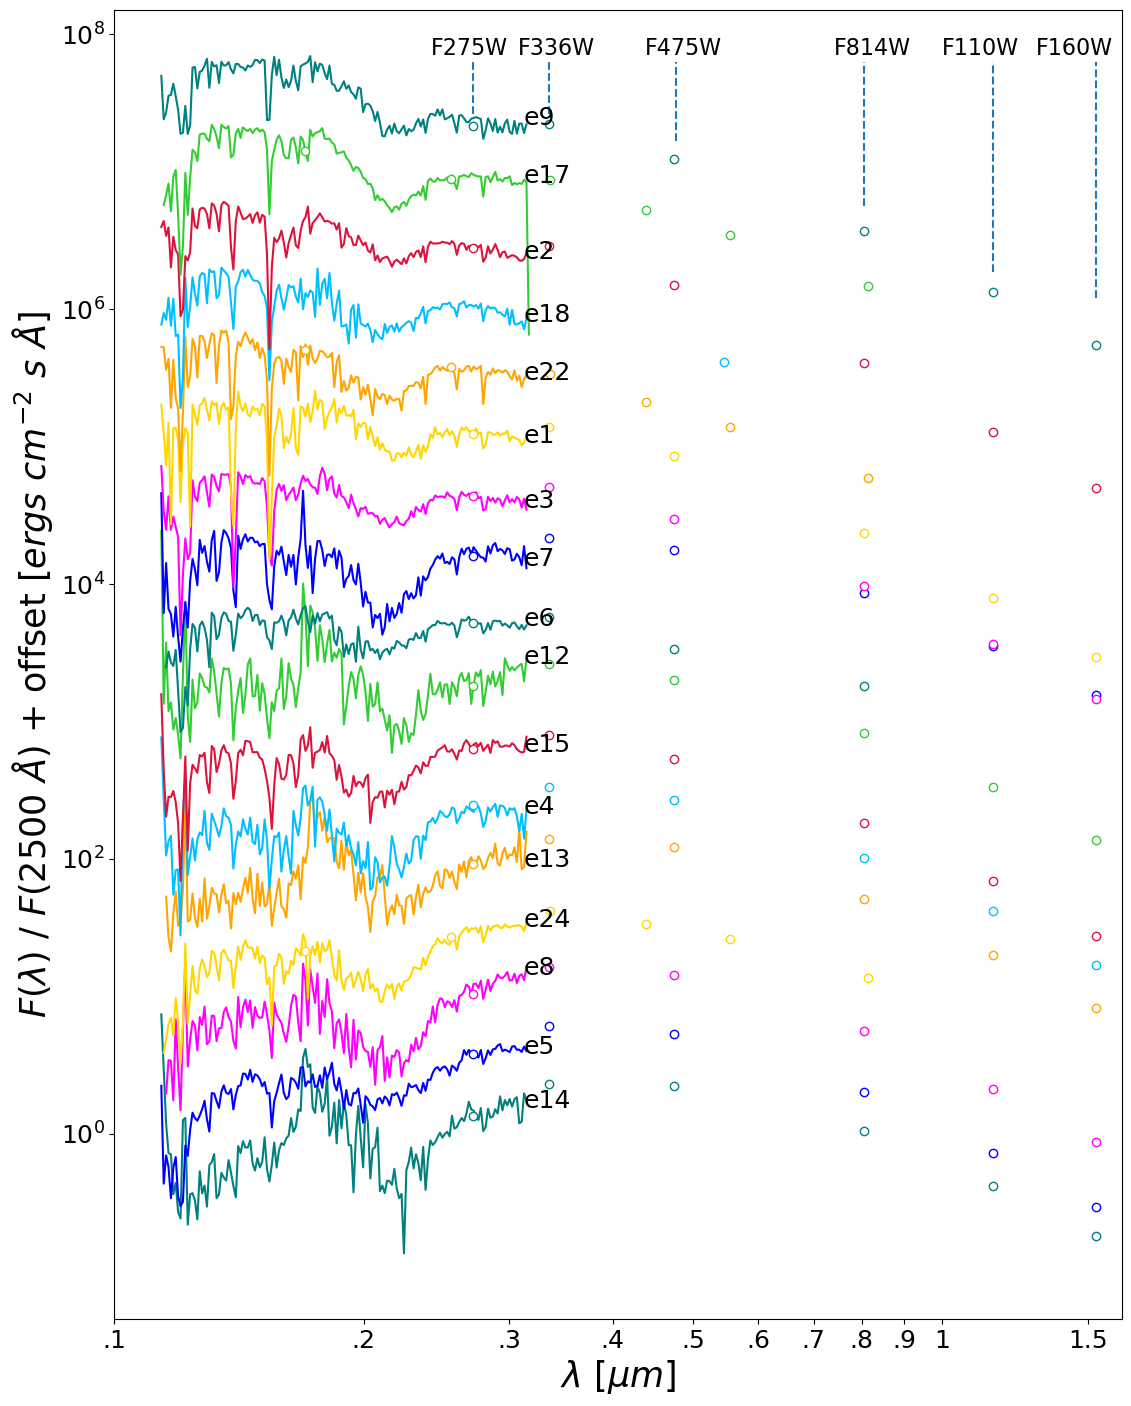

In [31]:
nstr = 30

m31_list_full = True
measure_slopes = True
plot_4_m31_2015_stars = True

# m31_list = [
#     "m31_e2_j004413.84+414903.9",
#     "m31_e3_j004420.52+411751.1", 
#     "m31_e4_j004427.47+415150.0",
#     "m31_e5_j004431.66+413612.4",
#     "m31_e6_j004438.71+415553.5", # MCMC fitter error:
        # UnboundLocalError: local variable 'fit_params_best' referenced before assignment
#     "m31_e7_j004454.37+412823.9",
#     "m31_e8_j004511.82+415025.3",
#     "m31_e9_j004511.85+413712.9", 
#     "m31_e12_j004539.00+415439.0",
#     "m31_e13_j004539.70+415054.8",
#     "m31_e14_j004543.46+414513.6", # Prob. w sorting by UV slope
#     "m31_e15_j004546.81+415431.7", # UnboundLocalError: local variable 'fit_params_best' referenced before assignment
#]


if m31_list is None:
    if galaxy == 'm31':
        m31_list = [
                    "m31_e2_j004413.84+414903.9",
                    "m31_e3_j004420.52+411751.1", # ValueError: Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance
                    "m31_e4_j004427.47+415150.0",
                    "m31_e5_j004431.66+413612.4",
                    "m31_e7_j004454.37+412823.9",
                    "m31_e8_j004511.82+415025.3",
                    "m31_e9_j004511.85+413712.9", 
                    "m31_e12_j004539.00+415439.0",
                    "m31_e13_j004539.70+415054.8",
                    "m31_e15_j004546.81+415431.7", # UnboundLocalError: local variable 'fit_params_best' referenced before assignment
                    ]
                    # "m31_e6_j004438.71+415553.5", # error
                    # "m31_e1_j004354.05+412626.0", # Prob. w sorting by UV slope
                    # "m31_e10_j004512.73+413726.4", "m31_e11_j004535.40+414431.5", #No STIS data for e10 & e11
                    # "m31_e14_j004543.46+414513.6", # Prob. w sorting by UV slope
    else:
        m31_list = ["m33_e1_j013334.26+303327", "m33_e2_j013339.52+304540",
                    "m33_e4_j013344.59+304436", "m33_e7_j012241.93+304728", 
                    #"m33_e3_j013250.80+303507", "m33_e5_j013406.63+304147", 
                    #"m33_e6_j013410.59+304616", "m33_e8_j013416.10+303344.9"
                   ]
    
if m31_list_full:
    if galaxy == "m33":
        m31_list = [
                    "m33_e1_j013334.26+303327", 
                    "m33_e2_j013339.52+304540",
                    "m33_e3_j013250.80+303507", 
                    "m33_e4_j013344.59+304436", 
                    "m33_e5_j013406.63+304147", 
                    # "m33_e6_j013410.59+304616", # bad spectra
                    "m33_e7_j012241.93+304728", 
                    # "m33_e8_j013416.10+303344.9" # half spectra
                   ]
    else:
        m31_list = [
                    "m31_e2_j004413.84+414903.9","m31_e3_j004420.52+411751.1",
                    "m31_e4_j004427.47+415150.0","m31_e5_j004431.66+413612.4",
                    "m31_e7_j004454.37+412823.9","m31_e8_j004511.82+415025.3","m31_e9_j004511.85+413712.9", 
                    "m31_e12_j004539.00+415439.0","m31_e13_j004539.70+415054.8",
                    "m31_e14_j004543.46+414513.6",
                    "m31_e15_j004546.81+415431.7",
]

        if plot_4_m31_2015_stars:
            m31_list = [
                        "m31_e1_j004354.05+412626.0",
                        "m31_e2_j004413.84+414903.9","m31_e3_j004420.52+411751.1",
                        "m31_e4_j004427.47+415150.0","m31_e5_j004431.66+413612.4",
                        "m31_e6_j004438.71+415553.5",
                        "m31_e7_j004454.37+412823.9","m31_e8_j004511.82+415025.3","m31_e9_j004511.85+413712.9", 
                        "m31_e12_j004539.00+415439.0","m31_e13_j004539.70+415054.8",
                        "m31_e14_j004543.46+414513.6",
                        "m31_e15_j004546.81+415431.7",
                        "m31_e17_j003944.71+402056.2",
                        "m31_e18_j003958.22+402329.0",
                        "m31_e22_j004034.61+404326.1",
                        "m31_e24_j004412.17+413324.2",
    ]
                    # "m31_e10_j004512.73+413726.4", "m31_e11_j004535.40+414431.5", #No STIS data for e10 & e11]
else:
    if galaxy == "m33":
        m31_list = ["m33_e1_j013334.26+303327", "m33_e2_j013339.52+304540",
                    "m33_e4_j013344.59+304436", "m33_e7_j012241.93+304728", 
                   ]
    else:
        m31_list = [
        # "m31_e1_j004354.05+412626.0",
                    "m31_e2_j004413.84+414903.9","m31_e3_j004420.52+411751.1",
                    "m31_e4_j004427.47+415150.0","m31_e5_j004431.66+413612.4",
                    # "m31_e6_j004438.71+415553.5",
                    "m31_e7_j004454.37+412823.9","m31_e8_j004511.82+415025.3","m31_e9_j004511.85+413712.9", 
                    "m31_e12_j004539.00+415439.0","m31_e13_j004539.70+415054.8",
                    # "m31_e14_j004543.46+414513.6",
                    "m31_e15_j004546.81+415431.7"]
        
# print(m31_list)
    
if measure_slopes:
    # Measure the UV slope so spectra can be ordered by it
    slopes = []
    for i, st in enumerate(m31_list):
        starname = st
        # print("st", st)
        # print("starname", starname)
        fstarname = f"{starname}.dat"
        starstr = starname.split(gal_str)[1].split("_")[0]
        print(starstr)

        reddened_star, band_names, data_names = get_red_star(fstarname, file_path)

        v1 = np.logical_and(
                    reddened_star.data["STIS"].waves > 0.125 * u.micron,
                    reddened_star.data["STIS"].waves < 0.145 * u.micron,
                )
    #     vr1 = np.logical_and(v1, reddened_star.data["STIS"].npts > 0)
        v2 = np.logical_and(
                    reddened_star.data["STIS"].waves > 0.25 * u.micron,
                    reddened_star.data["STIS"].waves < 0.30 * u.micron,
                )

        slopes.append(
                    np.median(reddened_star.data["STIS"].fluxes[v1])
                    / np.median(reddened_star.data["STIS"].fluxes[v2])
                )
    # print("slopes", slopes)
    m31_list_arr = np.array(m31_list)
    # Order stars by UV slope
    m31_list_uvsort = m31_list_arr[np.argsort(slopes)]
                
m31_list_arr = np.array(m31_list)
if measure_slopes is False:
    m31_list_uvsort = m31_list_arr

# Sorted in ascending UV slope order
# print("m31_list UV sorted", m31_list_uvsort)

# ============================================================================
fs=14
norm_data = np.average(red_star.data["BAND"].fluxes)
# norm_flux = red_star.data[cspec].fluxes / norm_data

# Define normalization WL
norm_wr = [0.24, 0.26] * u.micron

# colors = cycle(['teal', 'blue', 'magenta', 'gold', 'orange', 'deepskyblue'])
# colors = cycle(['blue', 'magenta', 'blue', 'magenta','blue', 'magenta'])
if m31_list_full:
    colors = cycle(['teal', 'blue', 'magenta', 'gold', 'orange', 'deepskyblue', 'crimson', 'limegreen', ])
else:
    colors = cycle(['teal', 'blue', 'magenta', 'orange'])

plot_one=False

yot='multiply'
half_num = len(m31_list) // 2 + 1

# fig, ax = plt.subplots(figsize=(13, 20))
ncols=1
fig, ax = plt.subplots(ncols=ncols, figsize=(13, 17))
spec_adj = 0.0

# Choose whether to use the UV-slope-sorted list
for i, st in enumerate(m31_list_uvsort): # m31_list_uvsort
    # print("Offset spectra plot", i)
    if plot_one:
        fstarname = f"{starname}.dat"
    else:
        starname = st
        # print(starname)
        fstarname = f"{starname}.dat"
    starstr = starname.split(gal_str)[1].split("_")[0]

    reddened_star, band_names, data_names = get_red_star(fstarname, file_path)
    
    # Remove negative fluxes
    nvals = reddened_star.data["STIS"].fluxes < 0
    reddened_star.data["STIS"].npts[nvals] = 0

    # Rebin spectra
    reddened_star.data["STIS"].rebin_constres(rwaverange, gres)
    
    # If the entry is in the list's second half, offset by a number near star index
    if i // half_num > 0:
        offset = 2.5 ** (i - half_num)
        annotate_yoffset = 2.5 ** (0.05*(i - half_num))
    else:
        offset = 2.5 ** i
        annotate_yoffset = 2.5 ** (0.05*i)

    offset = 2.9 ** i #2.5 ** i
    annotate_yoffset = 0.0

    # Adjust spectra
    spec_adj = spec_corr(galaxy, starstr)
    # rb_data_adj = rb_data.value * spec_adj 
    
    reddened_star.data["STIS"].fluxes = (reddened_star.data["STIS"].fluxes.value * spec_adj) * (u.erg / ((u.cm ** 2) * u.s * u.angstrom))

#     spec_rb = reddened_star.data["STIS"]
#     spec_rb.rebin_constres(rwaverange, gres)
#     rb_data = spec_rb.fluxes
#     rb_data_adj = spec_rb.fluxes.value

    ax_i=ax
    if ncols==2:
        ax_i = ax[i // half_num]
    reddened_star.plot(ax_i, 
                       pcolor=next(colors), 
                       yoffset=offset, 
                       yoffset_type=yot,
                       norm_wave_range=norm_wr,
                       annotate_key="STIS",
                       annotate_wave_range=[0.31, 0.315] * u.micron,
                       annotate_text=starstr,
                       annotate_rotation=-0.0,
                       annotate_yoffset=-0.2,
                       annotate_alignment='left',
                       fontsize=18)

    # Plot phot band names and lines
    if i==len(m31_list_uvsort)-1:
        # additional phometric filters for C15 4 stars:
        # F170W, F255W, F336W, F439W, F555W, F814W

        wfc3_bn = ["F275W","F336W","F475W","F814W","F110W","F160W"]
        wfc3_bw = np.array([0.2410, 0.307, 0.4372, 0.74, 1., 1.3])
        max_offset_bandflux = [100, 120, 70, 20, 8, 2]
        max_axis_range = [0.82, 0.82, 0.765, 0.62, 0.5, 0.4]

        wfc3_bw_exact = np.array([0.2710, 0.3355, 0.4772, 0.8053, 1.1534, 1.5369])

        for j in range(6):
            if galaxy == 'm33':
                # max_axis_range = [0.82, 0.82, 0.765, 0.62, 0.5, 0.4]
                max_axis_range = [0.84, 0.85, 0.78, 0.67, 0.57, 0.48]
                if m31_list_full:
                    ax_i.text(wfc3_bw[j], 300., '%s' % wfc3_bn[j], fontsize=16)
                else:
                    ax_i.text(wfc3_bw[j], 30, '%s' % wfc3_bn[j], fontsize=16)
                ax_i.axvline(wfc3_bw_exact[j], ymin=max_axis_range[j], ymax=0.91, linestyle='dashed')
            else:
                # max_axis_range = [0.85, 0.85, 0.81, 0.73, 0.66, 0.59]
                max_axis_range = [0.92, 0.92, 0.9, 0.85, 0.8, 0.78]

                if m31_list_full:
                    if plot_4_m31_2015_stars:
                        ax_i.text(wfc3_bw[j], 70000000., '%s' % wfc3_bn[j], fontsize=16)
                    else:
                        ax_i.text(wfc3_bw[j], 17000., '%s' % wfc3_bn[j], fontsize=16)
                # else:
                #     ax_i.text(wfc3_bw[j], 30, '%s' % wfc3_bn[j], fontsize=16)
                ax_i.axvline(wfc3_bw_exact[j], ymin=max_axis_range[j], ymax=0.96, linestyle='dashed')

# Set axes params and labels
ax_i=ax
if ncols==2:
    ax_i = ax[i]

xl = (0.1, 1.65)
ax_i.set_xlim(xl)

# ax_i.set_xlim(0.11, 0.32)
ylim = ax_i.get_ylim()

if yot is 'multiply':
    if m31_list_full:
        if galaxy=='m33':
            ax_i.set_ylim(2e-2, 650)
        else:
            ax_i.set_ylim(.04, 45000)
            if plot_4_m31_2015_stars:
                ax_i.set_ylim(.045, 1.5e8)
    else:
        ax_i.set_ylim(2e-2, 65)

ax_i.set_yscale("log")
ax_i.set_xscale("log")
ax_i.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.8 * fs)
ax_i.set_ylabel(
        r"$F(\lambda)$ / $F(2500~\AA)$ + offset [$ergs\ cm^{-2}\ s\ \AA$]",
        fontsize=1.8 * fs,
    )
ax_i.set_xticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1, 1.5], 
                labels=['.1','.2','.3','.4','.5','.6','.7','.8','.9','1', '1.5'])
ax_i.tick_params(axis='both', which='major', labelsize=18)
ax_i.tick_params(axis='both', which='minor', labelsize=18)
# ax_i.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax_i.xaxis.set_minor_locator(ticker.LogLocator(numticks=999, subs="auto"))

nstr+=1
plt.savefig(savefile_path + "spectra_offset/" + galaxy + "/" + \
            gal_str + str(gres) + "_post_upd_spec_" + str(nstr) + ".png", bbox_inches='tight')


### Create the weight arrays based on the observed uncertainties

In [32]:
def set_weights(data_names, reddened_star):
    """
    """
    # cropping info for weights
    #  bad regions are defined as those where we know the models do not work
    #  or the data is bad
    # pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]
    ex_regions = [
        [8.23 - 0.1, 8.23 + 0.1],  # geocoronal line
        [8.7, 10.0],  # bad data from STIS
        [3.55, 3.6],
        [3.80, 3.90],
        [4.15, 4.3],
        [6.4, 6.6],
        [7.1, 7.3],
        [7.45, 7.55],
        [7.65, 7.75],
        [7.9, 7.95],
        [8.05, 8.1],
    ] / u.micron

    weights = {}
    for cspec in data_names:
        weights[cspec] = np.full(len(reddened_star.data[cspec].fluxes), 0.0)
        gvals = reddened_star.data[cspec].npts > 0
        weights[cspec][gvals] = 1.0 / reddened_star.data[cspec].uncs[gvals].value

        x = 1.0 / reddened_star.data[cspec].waves
        for cexreg in ex_regions:
            weights[cspec][np.logical_and(x >= cexreg[0], x <= cexreg[1])] = 0.0

    # make the photometric bands have higher weight
    # weights["BAND"] *= 10000.0
    print("weight arrays set")
    return weights

### Setup the fit parameters

In [33]:
def setparams(modinfo, logt=4.25, logg=3.09, logz=0.0, av=0.75, rv=3.1, c2=2.5, c3=0.65, c4=0.26, \
              x0=4.66, g=0.86 , hig=21.0, himw=19.0):
    """
    Set the initial starting position, customize for each star.
    # SMC metallicity -> 0.2 (1/5 solar)
    # Orig params = [4.25, 3.09, 0.2, 0.75, 3.7, 2.5, 0.65, 0.26, 4.66, 0.86, 22.0, 19.0]
    """
    # parameter names
    pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]

    params = [logt, logg, logz, av, rv, c2, c3, c4, x0, g, hig, himw]

    # min/max allowed values for each parameter
    # some are based on the min/max of the stellar atmosphere grid
    plimits = [
            [modinfo.temps_min, modinfo.temps_max],  # log(Teff)
            [modinfo.gravs_min, modinfo.gravs_max],  # log(g)
            [modinfo.mets_min, modinfo.mets_max],    # log(Z)
            [0.0, 4.0],   # Av
            [2.0, 6.0],   # Rv
            [-0.1, 5.0],  # C2
            [0.0, 2.5],   # C3
            [0.0, 1.0],   # C4
            [4.55, 4.65],   # x0
            [0.6, 1.5],   # gamma
            [17.0, 24.0], # log(HI) internal to galaxy
            [17.0, 22.0], # log(HI) MW foreground
        ]

    # add Gaussian priors based on prior knowledge
    #  sptype -> log(Teff), log(g)
    #  galaxy metallicity -> log(Z)
    print("Priors are logT={}, logg={}, logZ={}".format(logt, logg, logz))
    ppriors = {}
    ppriors["logT"] = (logt, 0.01)
    ppriors["logg"] = (logg, 0.1)
    ppriors["logZ"] = (logz, 0.1)

    return pnames, params, plimits, ppriors    

### Package the fit info needed.  FitInfo class defines the likelihood functions as well.

In [34]:
def package_fitinfo(pnames, plimits, weights, ppriors, velocity):
    """
    """
    print('ppriors',ppriors)
    fitinfo = FitInfo(
        pnames,
        plimits,
        weights,
        parameter_priors=ppriors,
        stellar_velocity=velocity,
    )
    return fitinfo

### Turn log(likelihood) into chi^2
Needed since op.minimize searchs for the min chisqr (not max likelihood like MCMC algorithms)

In [35]:
def nll(*args):
    return -fitinfo.lnprob(*args)

# simple function to turn the log(likelihood) into the chisqr
def log_l_to_chi2(fitinfo, params, reddened_star, modinfo, method="Nelder-Mead"): #, maxiter
    """
    nll = function to be minimized
    params = initial guess
    method = type of solver
    args = extra arguments passed to the fn to be minimized
    """
# result = op.minimize(
#    nll, params, method="Nelder-Mead", args=(reddened_star, modinfo, fitinfo)
# def lnprob(params, obsdata, modeldata, fitinfo):

    # run the fit
#     nll_w_fitinfo = -fitinfo.lnprob(reddened_star, modinfo, fitinfo)
    result = op.minimize(
        nll, params, method="Nelder-Mead", 
        args=(reddened_star, modinfo, fitinfo), options={"maxiter": 1000})
    print("\n\n PPRIORS ", fitinfo.parameter_priors, "\n\n")
    # check the fit output
    print("in log_l_to_chi2.", result["message"])
    print("Success?", result["success"])
    return result

### Save dust param results based on optimizer calc

In [36]:
def save_results(result, pnames, print=False):
    """
    """
    params = result["x"]
    fit_params = params
    params_best = params
    pnames_extra = pnames

    if print:
        print("Best fit")
        for k, val in enumerate(params_best):
            print("{} # {}".format(val, pnames_extra[k]))
        
    return params, fit_params, params_best, pnames_extra

### Calculate and save the extinction curve (longer version)

In [37]:
def calc_plot_ext_curve(modinfo,
                        fit_params, 
                        velocity, 
                        relband, 
                        reddened_star, 
                        starname, 
                        params, 
                        starstr,
                        save_ext_curve,
                        plot_ext_curve):
    """
    """
    # intrinsic sed: log(T), log(g), Z, Av
    modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)

    # dust_extinguished sed: Av, etc.
    ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

    # hi_abs sed
    hi_ext_modsed = modinfo.hi_abs_sed(
        fit_params[10:12], [velocity, 0.0], ext_modsed)

    # create a StarData object for the best fit SED
    modsed_stardata = modinfo.SED_to_StarData(modsed)

    # create an extincion curve and save it
    extdata = ExtData()
#     Calculate the E(lambda-X) for the photometric band data
    extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
    col_info = {"av": fit_params[3], "rv": fit_params[4]}
    
    if save_ext_curve:
        print("Saving extinction curve")
        extdata.save("extcurves/" + gal_str + '/' + "m33_" + starstr + "_ext_rb_" + str(gres) + "res.fits", column_info=col_info)
        print("extinction curve type", extdata.type)
    
    # =============== PLOT the extinction curve =========================
    if plot_ext_curve:
        fig, ax = plt.subplots(figsize=(13, 10))

        # convert from E(l-V) to A(l)/A(V)
        extdata.columns["AV"] = (params[3], 0.0)
        # extdata.trans_elv_alav()
        # extdata.trans_elv_elvebv()

        # Data
        extdata.plot(ax, color='k') #, lw=1.3) #'deepskyblue')#, alax=True)
        ax.set_xscale("log")
        ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
        # ax.set_ylim(0.0, 10.0)
        ax.set_ylabel(fr"$E(\lambda$ - %s)" % relband_str, fontsize=1.3 * fontsize)
        ax.tick_params("both", length=10, width=2, which="major")
        ax.tick_params("both", length=5, width=1, which="minor")

        # plot known exitnction curves
        mod_x = np.arange(0.3, 8.7, 0.1) / u.micron
        smcbar = G03_SMCBar()
        Af475wAv = smcbar(0.475 * u.micron)
        smcbar_el475w = (smcbar(mod_x) - Af475wAv) * params[3]
        ax.plot(1.0 / mod_x, smcbar_el475w, "b", label="SMC Bar, G03", lw=1.) # "k:"

        f19_rv31 = F19(Rv=3.1)
        Af475wAv = f19_rv31(0.475 * u.micron)
        f19_el475w = (f19_rv31(mod_x) - Af475wAv) * params[3]
        ax.plot(1.0 / mod_x, f19_el475w, "r", lw=1., label="MW Rv=3.1, F19") #"k-"
        
        lmcave = G03_LMCAvg()
        Af475wAv = lmcave(0.475 * u.micron)
        lmcave_el475w = (lmcave(mod_x) - Af475wAv) * params[3]
        ax.plot(1.0 / mod_x, lmcave_el475w, "g", label="LMC Ave, G03", lw=1.)

        ax.set_title("%s" % starname)
        ax.legend()
        plt.savefig(savefile_path + "ext_curves/" + gal_str + '/' + gal_str + starstr + "_extcurve_" + str(gres) + "_res_spec_upd_w_spt.png")
    
    return modsed, ext_modsed, hi_ext_modsed, modsed_stardata, extdata, col_info

### Save ext curve (quick, no optimizer needed)

In [38]:
def save_ext_curve_quick(fit_params, velocity, modsed):
    """
    """
    
    # intrinsic sed
    modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)

    # dust_extinguished sed
    ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

    # hi_abs sed
    hi_ext_modsed = modinfo.hi_abs_sed(
        fit_params[10:12], [velocity, 0.0], ext_modsed
    )

    # create a StarData object for the best fit SED
    modsed_stardata = modinfo.SED_to_StarData(modsed)

    # create an extincion curve and save it
    extdata = ExtData()
    extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
    col_info = {"av": fit_params[3], "rv": fit_params[4]}
    extdata.save(gal_str + starname + "_ext.fits", column_info=col_info)

### Read initial positions from file

In [39]:
def read_init_pos(starstr):
    """
    Read in the params specifying the best-fit intial position
    """
    
    print("\nstarname", starname, "\n")
    #gal = "m33/"
    print('galaxy, in read_inti_pos', galaxy)

    initial_pos_file = "initial_pos/" + galaxy + "/" + starstr + "_start.dat" 
    ipdata = np.fromfile(initial_pos_file, dtype="float", sep=" ")
    print('init pos file', initial_pos_file)
    print('test: ipdata[0]', ipdata[0])
    
    if len(ipdata) < 12 or len(ipdata) > 12:
        print("WARNING: Initial position data has fewer/more elements than expected.")

    logtgrid = [ipdata[0]]
    logggrid = [ipdata[1]]
    logzgrid = [ipdata[2]]
    avgrid = [ipdata[3]]
    rvgrid = [ipdata[4]]
    c2grid = [ipdata[5]]
    c3grid = [ipdata[6]]
    c4grid = [ipdata[7]]
    x0grid = [ipdata[8]]
    gammagrid = [ipdata[9]]
    hi_galgrid = [ipdata[10]]
    hi_mwgrid = [ipdata[11]]

    return logtgrid, logggrid, logzgrid, \
            avgrid, rvgrid, c2grid, c3grid, \
            c4grid, x0grid, gammagrid, \
            hi_galgrid, hi_mwgrid


### Set up parameter grid ranges

In [40]:
def setup_param_ranges(starname, starstr, small_vary=False):
    """
    """
    # print("starname", starname)
    print("starstr", starstr)
    singlevalued = True

    # pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]

    # Get initial positions
    logtgrid, logggrid, logzgrid, \
        avgrid, rvgrid, c2grid, c3grid, \
        c4grid, x0grid, gammagrid, \
        hi_galgrid, hi_mwgrid = read_init_pos(starstr)
    
    initial_grid = [logtgrid, logggrid, logzgrid, avgrid, rvgrid, c2grid, c3grid, \
                    c4grid, x0grid, gammagrid, hi_galgrid, hi_mwgrid]
    
    if singlevalued is False:
        # Introduce a small variation around the orig initial position
        if small_vary:
            print("small vary")
        # log(T) [4.11 4.31]
        # log(g) [2.55 2.85]
        # log(Z) [-0.1  0.1]
        # Av [0.9 1.1]
        # Rv [3.1]
        # c2 [1.2 1.4]
        # c3 [2.  2.2 2.4]
        # c4 [-0.11  0.09]
        # x0 [4.55 4.6 ]
        # gamma [0.65 0.85]
        # HI_gal [20. 21.]
        # HI_MW [18. 19.]
            logtgrid = np.arange(logtgrid[0]-0.15, logtgrid[0]+0.15, 0.2)
            logggrid = np.arange(logggrid[0]-0.2, logggrid[0]+0.2, 0.3)
            logzgrid = np.arange(-0.1, 0.2, 0.2)
            avgrid = np.arange(avgrid[0]-0.2, avgrid[0]+0.2, 0.2)
            rvgrid = [rvgrid[0]]
            c2grid = np.arange(c2grid[0]-0.2, c2grid[0]+0.2, 0.2) 
            c3grid = np.arange(c3grid[0]-0.15, c3grid[0]+0.15, 0.2)  
            if starstr == "e7":
                print("c4, e7")
                c4grid = np.arange(c4grid[0]-0.05, c4grid[0]+0.4, 0.3)
            elif starstr == 'e9':
                print("c4, e9, c4grid[0]", c4grid[0])
                c4grid = np.arange(c4grid[0]+0.03, c4grid[0]+0.6, 0.3)
            else:
                c4grid = np.arange(c4grid[0]-0.2, c4grid[0]+0.2, 0.2)
            x0grid = np.arange(x0grid[0]-0.05, x0grid[0]+0.05, 0.05)
            gammagrid = np.arange(gammagrid[0]-0.2, gammagrid[0]+0.1, 0.2)
            if starstr == "e8":
                hi_galgrid = np.arange(hi_galgrid[0], hi_galgrid[0]+1, 0.5)
                hi_mwgrid = np.arange(hi_mwgrid[0], hi_mwgrid[0]+1, 0.5)
            else:
                hi_galgrid = np.arange(hi_galgrid[0]-1, hi_galgrid[0]+1, 1)
                hi_mwgrid = np.arange(hi_mwgrid[0]-1, hi_mwgrid[0]+1, 1)
        else:
            logtgrid = np.arange(4.4, 4.43, 0.02);    logggrid = np.arange(2.75, 3., 0.5)
            logzgrid = np.arange(-0.3, 0.4, 0.1);    avgrid = np.arange(1.2, 1.3, 0.05)
            rvgrid = np.arange(3.1, 3.15, 0.1);    c2grid = np.arange(1.3, 1.4, 0.1) 
            c3grid = np.arange(2.2, 2.3, 0.1);    c4grid = np.arange(0.05, 0.075, 0.01)
            x0grid = np.arange(4.65, 4.71, 0.05);    gammagrid = np.arange(0.9, 0.91, 0.05)
    
    print("From initial pos file")
    print("log(T)", logtgrid)
    print("log(g)", logggrid)
    print("log(Z)", logzgrid)
    print("Av", avgrid)
    print("Rv", rvgrid)
    print("c2", c2grid)
    print("c3", c3grid)
    print("c4", c4grid)
    print("x0", x0grid)
    print("gamma", gammagrid)
    print("HI_gal", hi_galgrid)
    print("HI_MW", hi_mwgrid)

    n_combos = len(logtgrid) * len(logggrid) * len(avgrid) * len(logzgrid) * \
                len(c2grid) * len(c3grid) * len(c4grid) * len(x0grid) * \
                len(gammagrid) * len(rvgrid) * len(hi_galgrid) * len(hi_mwgrid)
    # print("\nRun generates %s combination(s)" % n_combos)

    if n_combos > 2500:
        print("WARNING: Number of combinations is greater than 2500.")
    else:
        return initial_grid, logtgrid, logggrid, logzgrid, avgrid, rvgrid, c2grid, c3grid, c4grid, x0grid, gammagrid, hi_galgrid, hi_mwgrid

### Plot spectra: Intrinsic, Observations, Dust-extinguished

In [41]:
def plot_spectra_with_mod(modinfo, hi_ext_modsed, reddened_star, modsed, ext_modsed, \
                          modsed_stardata, starstr, params, initial_grid, runtype):
    """
    runtype:   (str) optimized or unoptimized fit
    """
    norm_model = np.average(hi_ext_modsed["BAND"])
    norm_data = np.average(reddened_star.data["BAND"].fluxes)

    # plotting setup for easier to read plots
    fontsize = 16
    font = {"size": fontsize}
    mpl.rc("font", **font)
    mpl.rc("lines", linewidth=1)
    mpl.rc("axes", linewidth=2)
    mpl.rc("xtick.major", width=2)
    mpl.rc("xtick.minor", width=2)
    mpl.rc("ytick.major", width=2)
    mpl.rc("ytick.minor", width=2)

    # setup the plot
    fig, ax = plt.subplots(figsize=(15, 13))

    # plot the bands and all spectra for this star
    for cspec in modinfo.fluxes.keys():
        if cspec == "BAND":
            ptype = "o"
        else:
            ptype = "-"

        # Observations
        ymult = 1.
            
        ax.plot(
            reddened_star.data[cspec].waves,
            reddened_star.data[cspec].fluxes / norm_data ,
            "k" + ptype,
            label="data")

        # Intrinsic SED
        ax.plot(
            modinfo.waves[cspec], 
            modsed[cspec] / norm_model * ymult, 
            "b" + ptype, label=cspec)
        
        # dust_extinguished sed
        ax.plot(
            modinfo.waves[cspec],
            ext_modsed[cspec] / norm_model,
            "r" + ptype,
            label=cspec)
        
        # hi abs sed
        ax.plot(
            modinfo.waves[cspec],
            hi_ext_modsed[cspec] / norm_model, ptype,
            color='limegreen',
            label=cspec)

    ax.set_yscale("log")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    ax.tick_params("both", length=10, width=2, which="major")
    ax.tick_params("both", length=5, width=1, which="minor")

    # use the whitespace better
    fig.tight_layout()
    
    # pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4",
    #"x0","gamma","HI_gal","HI_mw"]
    
    # print("params in plot_spectra_with_mod()", params)
    logt_round = np.around(params[0], decimals=2)
    logg_round = np.around(params[1], decimals=2)
    logz_round = np.around(params[2], decimals=2)
    av_round = np.around(params[3], decimals=2)
    rv_round = np.around(params[4], decimals=2)
    c2_round = np.around(params[5], decimals=2)
    c3_round = np.around(params[6], decimals=2)
    c4_round = np.around(params[7], decimals=2)
    x0_round = np.around(params[8], decimals=2)
    g_round = np.around(params[9], decimals=2)
    higal_round = np.around(params[10], decimals=2)
    himw_round = np.around(params[11], decimals=2)
    print("Fig params are log(T)=%s, log(g)=%s, Av=%s" % (params[0], params[1], params[3]))
    
    # Generate a name to record the star and its parameters
    param_combo_str = "_T_" + str(logt_round)  + "_g_" + str(logg_round) + \
                "_Z_" + str(logz_round) + \
                "_Av_"  + str(av_round) + "_Rv_" + str(rv_round) + "_c2_" + \
                str(c2_round) + "_c3_" + str(c3_round) + "_c4_" + str(c4_round) + "_x_" + \
                str(x0_round) + "_gam_" + str(g_round) + \
                "_HIgal_" + str(higal_round) + "_HImw_" + str(himw_round)
    # print("star", starstr)
    # print("\n param_combo_str", param_combo_str)
    
    ax.set_title(starstr + param_combo_str, y=0.95, fontsize=13)
    
    # Title with initial value for initial pos
    if initial_grid:
        param_combo_str_init = "_T_" + str(initial_grid[0][0])  + "_g_" + str(initial_grid[1][0]) + \
                    "_Z_" + str(initial_grid[2][0]) + \
                    "_Av_"  + str(initial_grid[3][0]) + "_Rv_" + str(initial_grid[4][0]) + "_c2_" + \
                    str(initial_grid[5][0]) + "_c3_" + str(initial_grid[6][0]) + "_c4_" + str(initial_grid[7][0]) + "_x_" + \
                    str(initial_grid[8][0]) + "_gam_" + str(initial_grid[9][0]) + \
                    "_HIgal_" + str(initial_grid[10][0]) + "_HImw_" + str(initial_grid[11][0])
    
    gal_folder = gal_str.split("_")[0] + "/"
    star_folder = starstr + "/"
    yl = ax.get_ylim()
    ax.set_ylim(0.1, yl[1])

    plt.savefig(savefile_path + "final_spectra/" + gal_folder + star_folder + \
                gal_str + starstr + "_phot_spec_" + runtype + param_combo_str + "_updSpT.png")

    # ax.set_ylim(0.01, 250)
    # yl = ax.get_ylim()
    if 'm31' in galaxy:
        if 'e2' in starstr:
            ax.set_ylim(0.1, 50)
    else:
        ax.set_ylim(0.105, yl[1])
    ax.set_xlim(0.10, 0.4)
    
    # Save also only spectra fit
    plt.savefig(savefile_path + "final_spectra/" + gal_folder + star_folder + \
                gal_str + starstr + "_spec_only_" + runtype + param_combo_str + "_updSpT.png")
    
    # print("Saved spectra w mod")

### Driver code calling all functions to calculate the extinction curve:
#### 1. Sets weight arrays
#### 2. Sets parameters
#### 3. Packages fitinfo
#### 4. log(likelihood) to the chisqr
#### 5. Saves result and prints best fit from initial guess
#### 6. Calculates extinction curve

In [53]:
print(m31_list)
# m31_list = m31_list[-4:]
# print(m31_list)
m31_list = ['m31_e1_j004354.05+412626.0', 
            'm31_e6_j004438.71+415553.5', 
            'm31_e14_j004543.46+414513.6', 
            'm31_e17_j003944.71+402056.2', 
            'm31_e18_j003958.22+402329.0', 
            'm31_e22_j004034.61+404326.1', 
            'm31_e24_j004412.17+413324.2']

['m31_e1_j004354.05+412626.0', 'm31_e2_j004413.84+414903.9', 'm31_e3_j004420.52+411751.1', 'm31_e4_j004427.47+415150.0', 'm31_e5_j004431.66+413612.4', 'm31_e6_j004438.71+415553.5', 'm31_e7_j004454.37+412823.9', 'm31_e8_j004511.82+415025.3', 'm31_e9_j004511.85+413712.9', 'm31_e12_j004539.00+415439.0', 'm31_e13_j004539.70+415054.8', 'm31_e14_j004543.46+414513.6', 'm31_e15_j004546.81+415431.7', 'm31_e17_j003944.71+402056.2', 'm31_e18_j003958.22+402329.0', 'm31_e22_j004034.61+404326.1', 'm31_e24_j004412.17+413324.2']


### Calculate all do_calc()

In [43]:
def do_calc(reddened_star, initial_grid, singlevalued, get_uncert=False, save_ext_curve=False,
            plot_ext_curve=False, plot_spectra=True):
    """
    Perform  ext curve calculation, consisting of:
    1. Setting the weights array
    2. Getting parameter limits and priors
    3. Package all in FitInfo object
    Then either:
    3a. Perform an MCMC fit to get uncertainties, or
    3b. Run the optimizer to get a quick fit
    """
    
    method="Nelder-Mead"#"Powell" 
    starstr = starname.split(gal_str)[1].split("_")[0]
    outfolder = "fit_/"

    # if not os.path.isdir(outfolder):
    #     print("making new dir", (outfolder))
    #     os.system("mkdir " + savefile_path + outfolder)

    # Create weight arrays
    weights = set_weights(data_names, reddened_star)

    if singlevalued:
        print("single-valued...")
        pnames, params, \
        plimits, ppriors = setparams(modinfo_rb, logtgrid[0], logggrid[0], 
                                     logzgrid[0], av=avgrid[0], rv=rvgrid[0],
                                     c2=c2grid[0], c3=c3grid[0], c4=c4grid[0], 
                                     x0=x0grid[0], g=gammagrid[0], hig=hi_galgrid[0], 
                                     himw=hi_mwgrid[0])
        print('setparams return', ppriors)
        # print("here fitinfo is obtained")
        fitinfo = package_fitinfo(pnames, plimits, weights, ppriors, velocity)

        # Get result inline
        def nll(*args):
            return -fitinfo.lnprob(*args)
        
        # Run MCMC sampler here to get ext curve params uncertainties
        if get_uncert:
            print("Starting MCMC sampler")
            mc_sampler(pnames, params, reddened_star, fitinfo)
            print("Done running MCMC sampler for uncert.")
            
            # Run optimizer to get result
            result = op.minimize(nll, params, method="Nelder-Mead", 
                                 args=(reddened_star, modinfo_rb, fitinfo), 
                                 options={"maxiter": 1000})

            params_opt, fit_params, params_best, pnames_extra = save_results(result, pnames)
            print("Params opt", params_opt)
            # long save ext curve
            if save_ext_curve or plot_ext_curve:
                print("Saving and plotting ext curve")
                modsed, ext_modsed, \
                hi_ext_modsed, modsed_stardata, \
                extdata, col_info = calc_plot_ext_curve(modinfo_rb, fit_params, 
                                                    velocity, relband, 
                                                    reddened_star, starname, 
                                                    params_opt, starstr,
                                                    save_ext_curve,
                                                    plot_ext_curve)
                
#                 def save_ext_curve_quick(fit_params, velocity, modsed):
            initial_grid=False
            runtype = 'mcmc'
            plot_spectra_with_mod(modinfo_rb, hi_ext_modsed, reddened_star, modsed, ext_modsed, 
                                    modsed_stardata, starstr, params_opt, initial_grid, runtype)
    
        # Or run the optimizer
        else:
            fit_params_1 = np.array(params)

            modsed_1, ext_modsed_1, \
            hi_ext_modsed_1, modsed_stardata_1, \
            extdata_1, col_info_1 = calc_plot_ext_curve(modinfo_rb, fit_params_1, 
                                                    velocity, relband, 
                                                    reddened_star, starname, 
                                                    params, starstr,
                                                    save_ext_curve,
                                                    plot_ext_curve)
            # Plot unoptimized fit
            print("\nUNOPTIMIZED fit:\n")
            runtype = 'unopt'
            plot_spectra_with_mod(modinfo_rb, hi_ext_modsed_1, reddened_star, modsed_1, 
                                  ext_modsed_1, modsed_stardata_1, starstr, params, 
                                  initial_grid, runtype)
            
            # ==================== Now optimize the fit ======================
            
            result = op.minimize(nll, params, method="Nelder-Mead", 
                                 args=(reddened_star, modinfo_rb, fitinfo), 
                                 options={"maxiter": 1000})

            # check the fit output
            print("Success?", result["success"])

            # Get result via a separate fn: does not work right now
#             result = log_l_to_chi2(fitinfo, params, reddened_star, 
#                                    modinfo=modinfo_rb, method=method)

            print("\nBefore opt, params are", fit_params_1)
            print("After opt, params are", result["x"])
            params_opt, fit_params, \
            params_best, pnames_extra = save_results(result, pnames)

            modsed, ext_modsed, \
            hi_ext_modsed, modsed_stardata, \
            extdata, col_info = calc_plot_ext_curve(modinfo_rb, fit_params, 
                                                    velocity, relband, 
                                                    reddened_star, starname, 
                                                    params_opt, starstr,
                                                    save_ext_curve,
                                                    plot_ext_curve)
            print("\n\n PARAMS_OPT\n\"", params_opt)

            # 2. Now plot optimized results: obs & mod spectra, and save it
            print("\nPlotting OPTIMIZED fit:\n")
            runtype = 'opt'
            plot_spectra_with_mod(modinfo_rb, hi_ext_modsed, reddened_star, modsed, 
                                  ext_modsed, modsed_stardata, starstr, params_opt, 
                                  initial_grid, runtype)

    else:
        for i in range(len(logtgrid)):
            for j in range(len(logggrid)):
                for k in range(len(logzgrid)):
                    for l in range(len(avgrid)):
                        for m in range(len(rvgrid)):
                            for n in range(len(c2grid)):
                                for o in range(len(c3grid)):
                                    for p in range(len(c4grid)):
                                        for q in range(len(x0grid)):
                                            for r in range(len(gammagrid)):
                                                for s in range(len(hi_galgrid)):
                                                    for t in range(len(hi_mwgrid)):
                                                        pnames, \
                                                        params, \
                                                        plimits, \
                                                        ppriors = setparams(modinfo_rb,
                                                                            logtgrid[i],
                                                                            logggrid[j],
                                                                            logzgrid[k],
                                                                            av=avgrid[l],
                                                                            rv=rvgrid[m],
                                                                            c2=c2grid[n], 
                                                                            c3=c3grid[o],
                                                                            c4=c4grid[p],
                                                                            x0=x0grid[q],
                                                                            g=gammagrid[r],
                                                                            hig=hi_galgrid[s], 
                                                                            himw=hi_mwgrid[t])
                                                
                                                fitinfo = package_fitinfo(pnames, plimits, 
                                                                          weights, ppriors, 
                                                                          velocity)

                                                # Get result inline
                                                def nll(*args):
                                                    return -fitinfo.lnprob(*args)

                                                # run the fit
                                                result = op.minimize(nll,
                                                                     params, 
                                                                     method="Nelder-Mead", 
                                                                     args=(reddened_star, modinfo_rb, fitinfo),
                                                                     options={"maxiter": 1000})

                                                params_opt, \
                                                fit_params, \
                                                params_best, \
                                                pnames_extra = save_results(result, pnames)

                            
                                                print("\n\n PARAMS_OPT\n\"", params_opt)
                                                modsed, \
                                                ext_modsed, \
                                                hi_ext_modsed, \
                                                modsed_stardata, \
                                                extdata, \
                                                col_info = calc_plot_ext_curve(modinfo_rb, fit_params, velocity, 
                                                                          relband, reddened_star, 
                                                                          starname, params_opt, starstr,
                                                                          save_ext_curve, plot_ext_curve)

                                                # Plot obs & mod spectra (based on initial guess), and save it
                                                plot_spectra_with_mod(modinfo_rb, hi_ext_modsed, reddened_star, modsed, ext_modsed, 
                                                               modsed_stardata, starstr, params, initial_grid)

                                                print('\n\n')

### Get Ext Curves or Initial Position one by one

In [58]:
# m31_list = ["m33_e1_j013334.26+303327", 
#             "m33_e2_j013339.52+304540",
#             "m33_e4_j013344.59+304436", 
#             "m33_e7_j012241.93+304728", 
#            ]
print(m31_list)
# limit for m31 to: e2, e3, e7:
# m31_list = ['m31_e2_j004413.84+414903.9', 'm31_e3_j004420.52+411751.1', 'm31_e7_j004454.37+412823.9']
print('Quick test m31 list: ', m31_list)
print('gal_str', gal_str)

['m31_e17_j003944.71+402056.2', 'm31_e18_j003958.22+402329.0', 'm31_e22_j004034.61+404326.1', 'm31_e24_j004412.17+413324.2']
Quick test m31 list:  ['m31_e17_j003944.71+402056.2', 'm31_e18_j003958.22+402329.0', 'm31_e22_j004034.61+404326.1', 'm31_e24_j004412.17+413324.2']
gal_str m31_


In [51]:
starname = m31_list[1]
print(starname)
starstr = starname.split(gal_str)[1].split("_")[0]
print(starstr)

m33_e2_j013339.52+304540
e2


### Define emcee MCMC sampler to calculate uncertainties

In [44]:
def mc_sampler(pnames, params, reddened_star, fitinfo):
    """
    """
    p0 = params
    ndim = len(p0)
#     print("p0", p0)

    #nwalkers = 2 * ndim
    #nsteps = 50
    #burn = 50

    nwalkers = 100 # 100
    nsteps = 500 #500 #10,000
    burn = 500 #500
    print("nwalkers:", nwalkers)
    print("nsteps:", nsteps)
    print("burn:", burn)

#     if get_uncert:
#      42             print("Starting MCMC sampler")
# ---> 43             mc_sampler(pnames, params, reddened_star, fitinfo)
#      44             print("Done running MCMC sampler for uncert.")
#    pos, prob, state = sampler.run_mcmc(p, burn)
# ValueError: Initial state has a large condition number. 
# Make sure that your walkers are linearly independent for the best performance

    # setting up the walkers to start "near" the inital guess
    p = [p0 * (1 + 0.01 * np.random.normal(0, 1.0, ndim)) for k in range(nwalkers)]

    # setup the sampler
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, fitinfo.lnprob, args=(reddened_star, modinfo_rb, fitinfo)
    )

    # burn in the walkers
    print("START burning in walkers")
    pos, prob, state = sampler.run_mcmc(p, burn)
    print("DONE burning in walkers")
    
    # reset the sampler
    sampler.reset()

    # do the full sampling
    print("START burning in walkers AFTER sampler reset")
    pos, prob, state = sampler.run_mcmc(pos, nsteps, rstate0=state)
    print("DONE burning in walkers AFTER sampler reset")
    # print ("pos", pos)
    # print ("prob", prob)
    # print ("state", state)

    # create the samples variable for later use
    print("Creating samples variable for later use")
    samples = sampler.chain.reshape((-1, ndim))
    print("DONE creating samples variable for later use")
    print("len samples", len(samples))

    # get the best fit values
    pnames_extra = pnames + ["E(B-V)", "N(HI)/A(V)", "N(HI)/E(B-V)"]
    params_best = get_best_fit_params(sampler)
    fit_params = params_best
    print("star", starstr)
    print("best params")
    print(params_best)

    # get the 16, 50, and 84 percentiles
    params_per = get_percentile_params(samples)
    print("params_per")
    print(params_per)

    for k, val in enumerate(params_per):
        print(
            "{} {} {} {} # {}".format(
                params_best[k], val[0], val[1], val[2], pnames_extra[k]
            )
        )
    
    # save params in a dat file
    save_mcmc_params(starstr, params_best, params_per, pnames_extra)

### Save MCMC params + uncert. to dat file

In [46]:
def save_mcmc_params(starstr, params_best, params_per, pnames_extra):
    """
    """
    # save the best fit and p50 +/- uncs values to a file; a single row table
    f = open("params_dat/" + galaxy + "/" + starstr + "_fit_params.dat", "w")
    #f.write("# best fit, p50, +unc, -unc\n")

#     pnames_extra = pnames + ["E(B-V)", "N(HI)/A(V)", "N(HI)/E(B-V)"]
#     params_per = get_percentile_params(samples)

    print("saving params...")
    for k, val in enumerate(params_per):
        f.write(
            "{} {} {} {} # {}\n".format(
               params_best[k], val[0], val[1], val[2], pnames_extra[k]
            )
        )
        print("done writing params")
    f.close()

### Run all

TypeError: list indices must be integers or slices, not tuple

Galaxy: m31_
starstr e1

starname m31_e1_j004354.05+412626.0 

galaxy, in read_inti_pos m31
init pos file initial_pos/m31/e1_start.dat
test: ipdata[0] 4.43
From initial pos file
log(T) [4.43]
log(g) [2.55]
log(Z) [0.1]
Av [1.8]
Rv [3.1]
c2 [1.1]
c3 [2.0]
c4 [-0.15]
x0 [4.6]
gamma [0.75]
HI_gal [21.0]
HI_MW [19.0]
weight arrays set
single-valued...
Priors are logT=4.43, logg=2.55, logZ=0.1
setparams return {'logT': (4.43, 0.01), 'logg': (2.55, 0.1), 'logZ': (0.1, 0.1)}
ppriors {'logT': (4.43, 0.01), 'logg': (2.55, 0.1), 'logZ': (0.1, 0.1)}
Saving extinction curve
extinction curve type elx


/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  # This is added back by InteractiveShellApp.init_path()



UNOPTIMIZED fit:

Fig params are log(T)=4.43, log(g)=2.55, Av=1.8


/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Success? False

Before opt, params are [ 4.43  2.55  0.1   1.8   3.1   1.1   2.   -0.15  4.6   0.75 21.   19.  ]
After opt, params are [ 4.43  2.55  0.1   1.8   3.1   1.1   2.   -0.15  4.6   0.75 21.   19.  ]
Saving extinction curve
extinction curve type elx


 PARAMS_OPT
" [ 4.43  2.55  0.1   1.8   3.1   1.1   2.   -0.15  4.6   0.75 21.   19.  ]

Plotting OPTIMIZED fit:

Fig params are log(T)=4.43, log(g)=2.55, Av=1.8
starstr e6

starname m31_e6_j004438.71+415553.5 

galaxy, in read_inti_pos m31
init pos file initial_pos/m31/e6_start.dat
test: ipdata[0] 4.25
From initial pos file
log(T) [4.25]
log(g) [2.95]
log(Z) [-0.1]
Av [1.0]
Rv [3.1]
c2 [1.3]
c3 [2.25]
c4 [0.06]
x0 [4.65]
gamma [0.9]
HI_gal [20.0]
HI_MW [18.0]
weight arrays set
single-valued...
Priors are logT=4.25, logg=2.95, logZ=-0.1
setparams return {'logT': (4.25, 0.01), 'logg': (2.95, 0.1), 'logZ': (-0.1, 0.1)}
ppriors {'logT': (4.25, 0.01), 'logg': (2.95, 0.1), 'logZ': (-0.1, 0.1)}
Saving extinction curve
extinction curve 

/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  # This is added back by InteractiveShellApp.init_path()
/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide



UNOPTIMIZED fit:

Fig params are log(T)=4.25, log(g)=2.95, Av=1.0


/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Success? False

Before opt, params are [ 4.25  2.95 -0.1   1.    3.1   1.3   2.25  0.06  4.65  0.9  20.   18.  ]
After opt, params are [ 4.25    2.95   -0.1     1.      3.1     1.3     2.25    0.06    4.8825
  0.9    20.     18.    ]
Saving extinction curve
extinction curve type elx


 PARAMS_OPT
" [ 4.25    2.95   -0.1     1.      3.1     1.3     2.25    0.06    4.8825
  0.9    20.     18.    ]

Plotting OPTIMIZED fit:

Fig params are log(T)=4.25, log(g)=2.95, Av=1.0
starstr e14

starname m31_e14_j004543.46+414513.6 

galaxy, in read_inti_pos m31
init pos file initial_pos/m31/e14_start.dat
test: ipdata[0] 4.23
From initial pos file
log(T) [4.23]
log(g) [2.79]
log(Z) [0.12]
Av [1.63]
Rv [2.96]
c2 [1.08]
c3 [2.07]
c4 [0.03]
x0 [4.55]
gamma [0.76]
HI_gal [17.0]
HI_MW [17.07]
weight arrays set
single-valued...
Priors are logT=4.23, logg=2.79, logZ=0.12
setparams return {'logT': (4.23, 0.01), 'logg': (2.79, 0.1), 'logZ': (0.12, 0.1)}
ppriors {'logT': (4.23, 0.01), 'logg': (2.79, 0.1), 'log

/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  # This is added back by InteractiveShellApp.init_path()



UNOPTIMIZED fit:

Fig params are log(T)=4.23, log(g)=2.79, Av=1.63


/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Success? False

Before opt, params are [ 4.23  2.79  0.12  1.63  2.96  1.08  2.07  0.03  4.55  0.76 17.   17.07]
After opt, params are [ 4.23    2.79    0.12    1.63    2.96    1.08    2.07    0.03    4.7775
  0.76   17.     17.07  ]
Saving extinction curve
extinction curve type elx


 PARAMS_OPT
" [ 4.23    2.79    0.12    1.63    2.96    1.08    2.07    0.03    4.7775
  0.76   17.     17.07  ]

Plotting OPTIMIZED fit:

Fig params are log(T)=4.23, log(g)=2.79, Av=1.63
starstr e17

starname m31_e17_j003944.71+402056.2 

galaxy, in read_inti_pos m31
init pos file initial_pos/m31/e17_start.dat
test: ipdata[0] 4.48
From initial pos file
log(T) [4.48]
log(g) [2.79]
log(Z) [0.03]
Av [1.085]
Rv [3.1]
c2 [0.65]
c3 [3.0]
c4 [0.41]
x0 [4.57]
gamma [1.07]
HI_gal [21.0]
HI_MW [19.0]
weight arrays set
single-valued...
Priors are logT=4.48, logg=2.79, logZ=0.03
setparams return {'logT': (4.48, 0.01), 'logg': (2.79, 0.1), 'logZ': (0.03, 0.1)}
ppriors {'logT': (4.48, 0.01), 'logg': (2.79, 0.1), 'logZ

/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  # This is added back by InteractiveShellApp.init_path()


TypeError: 'NoneType' object is not subscriptable

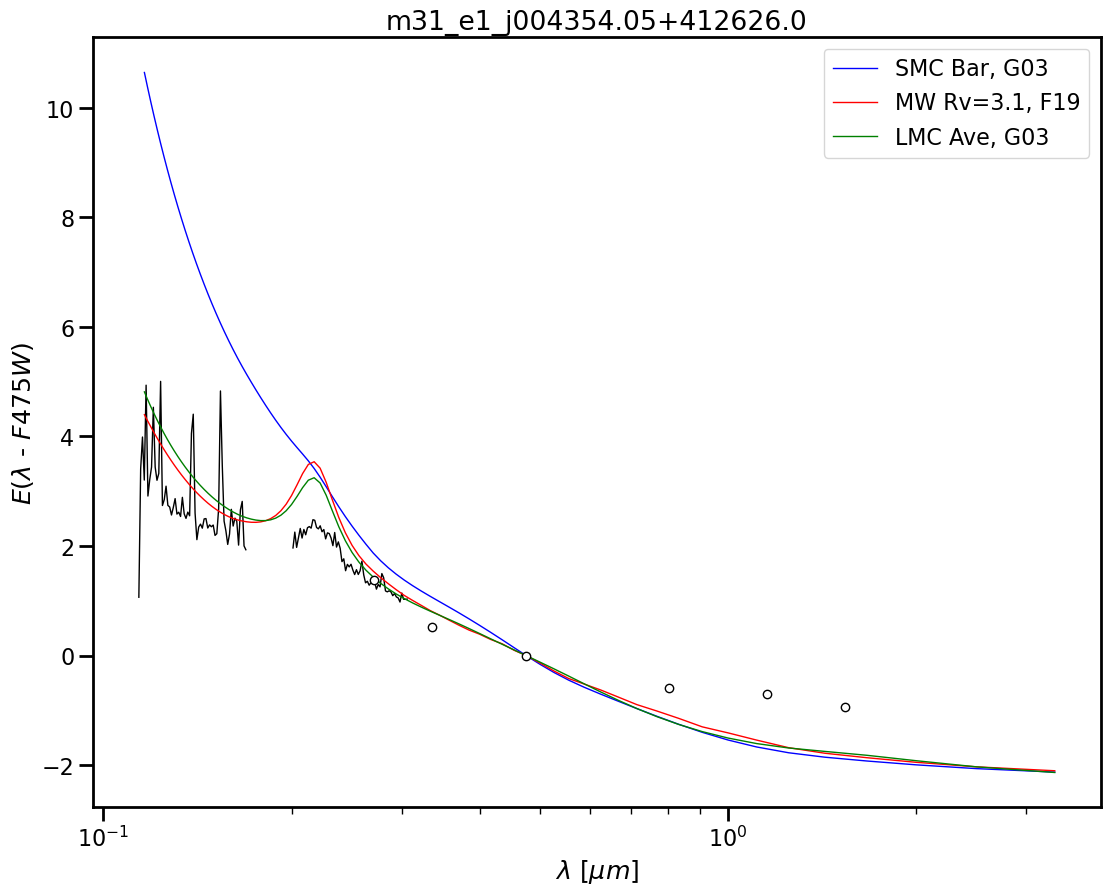

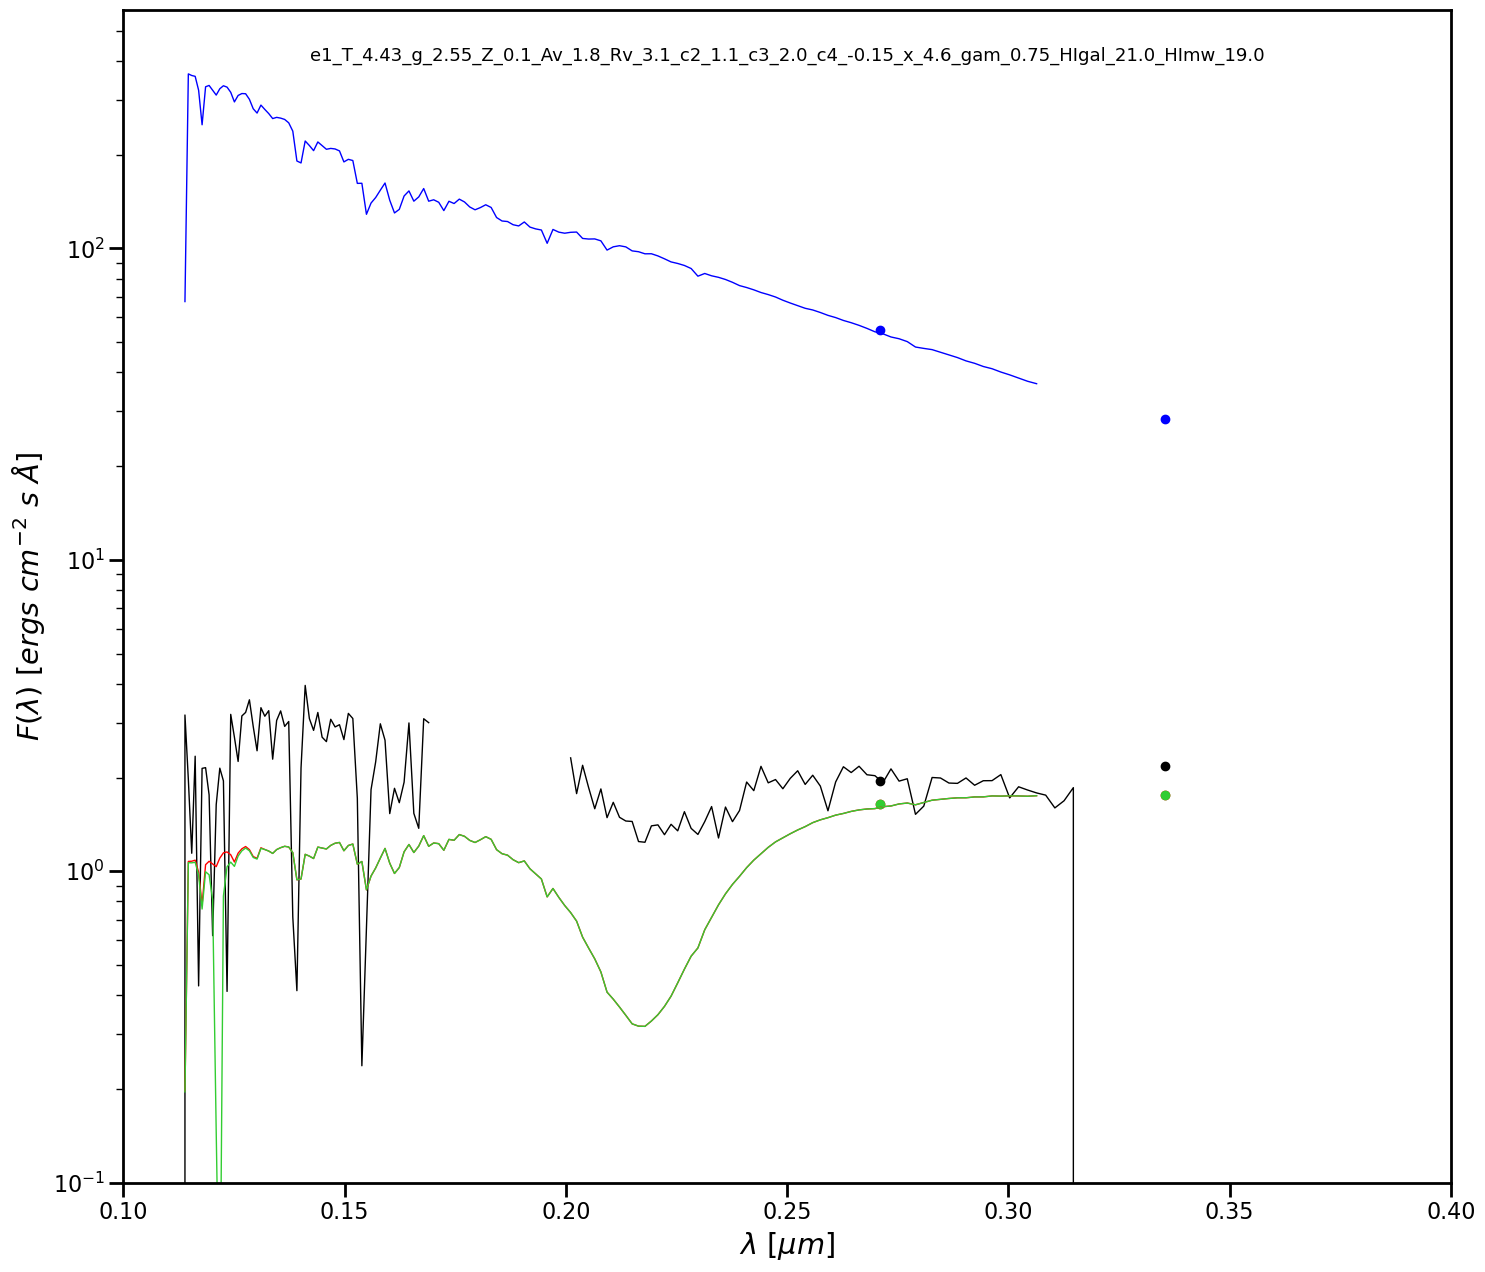

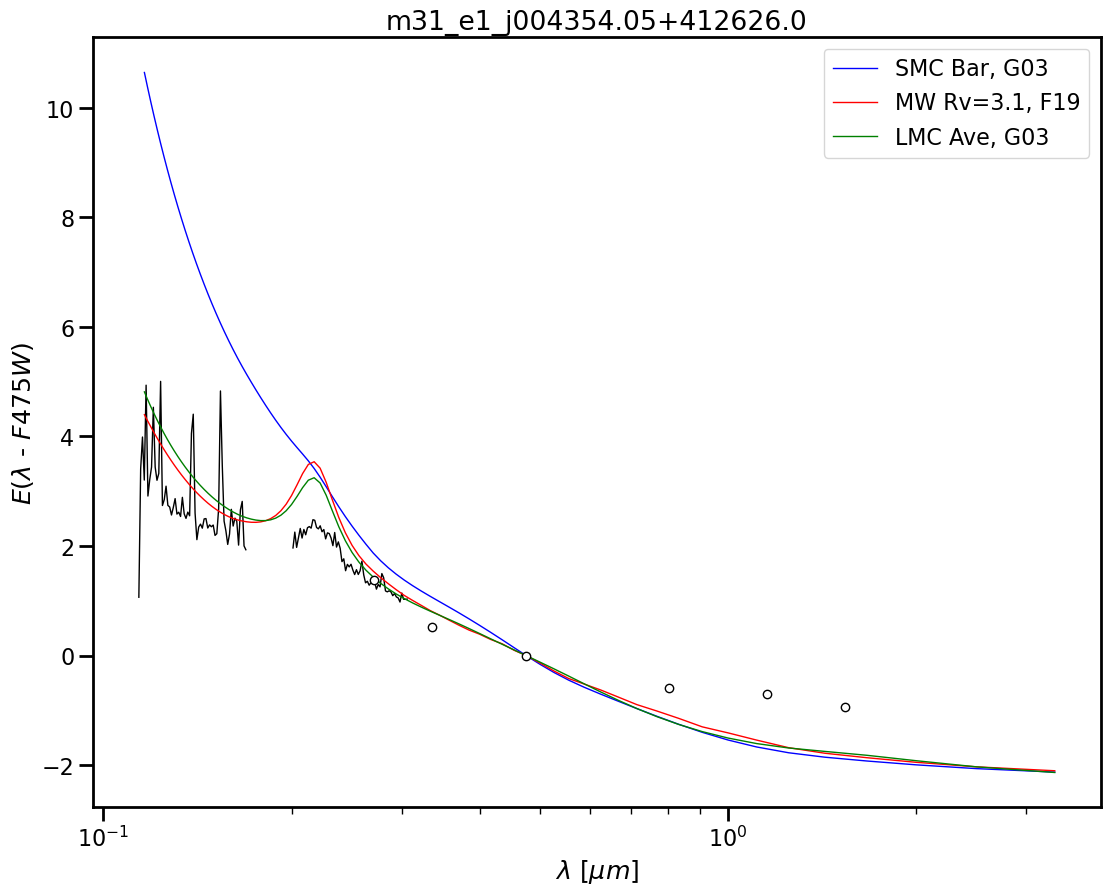

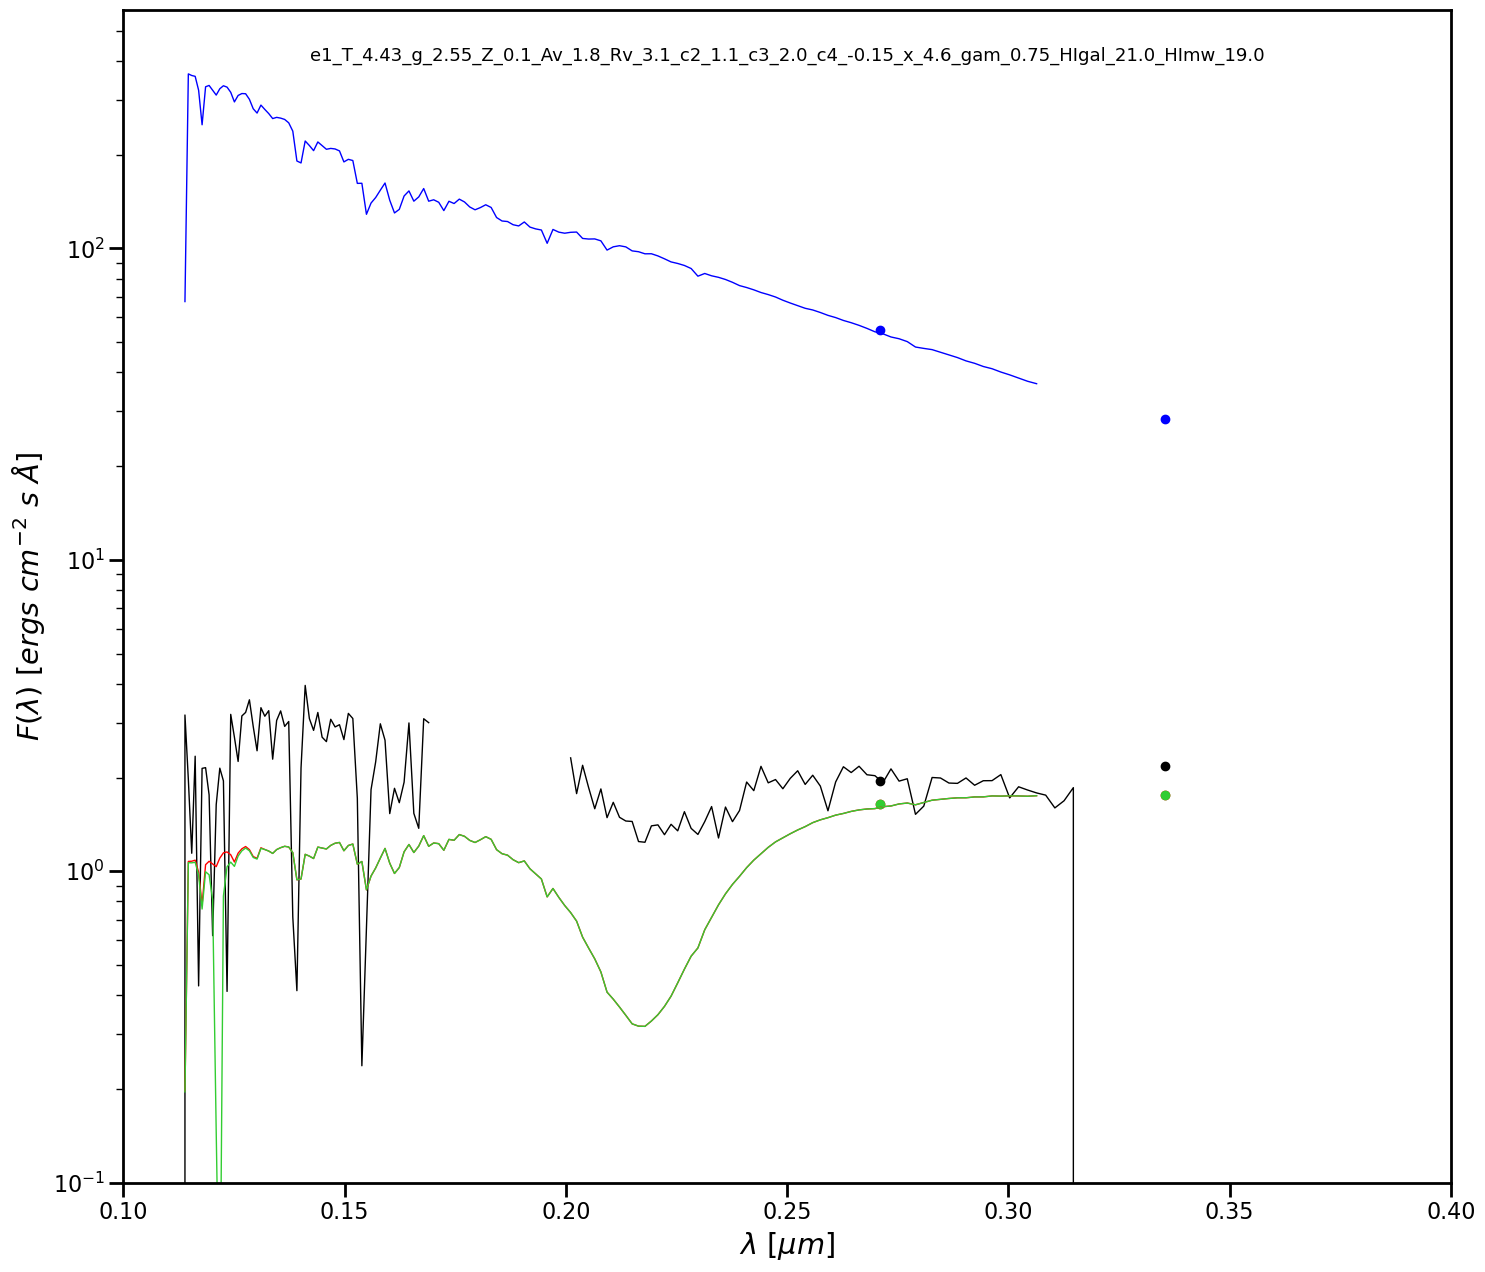

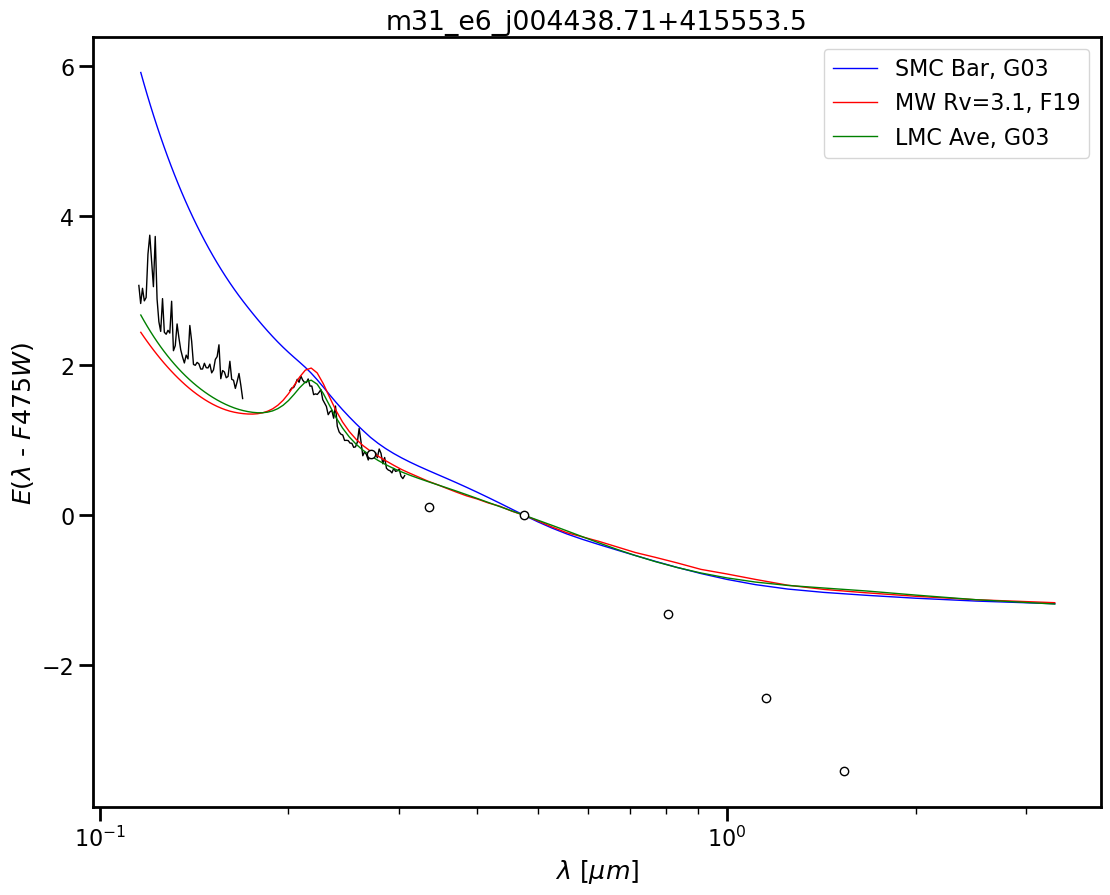

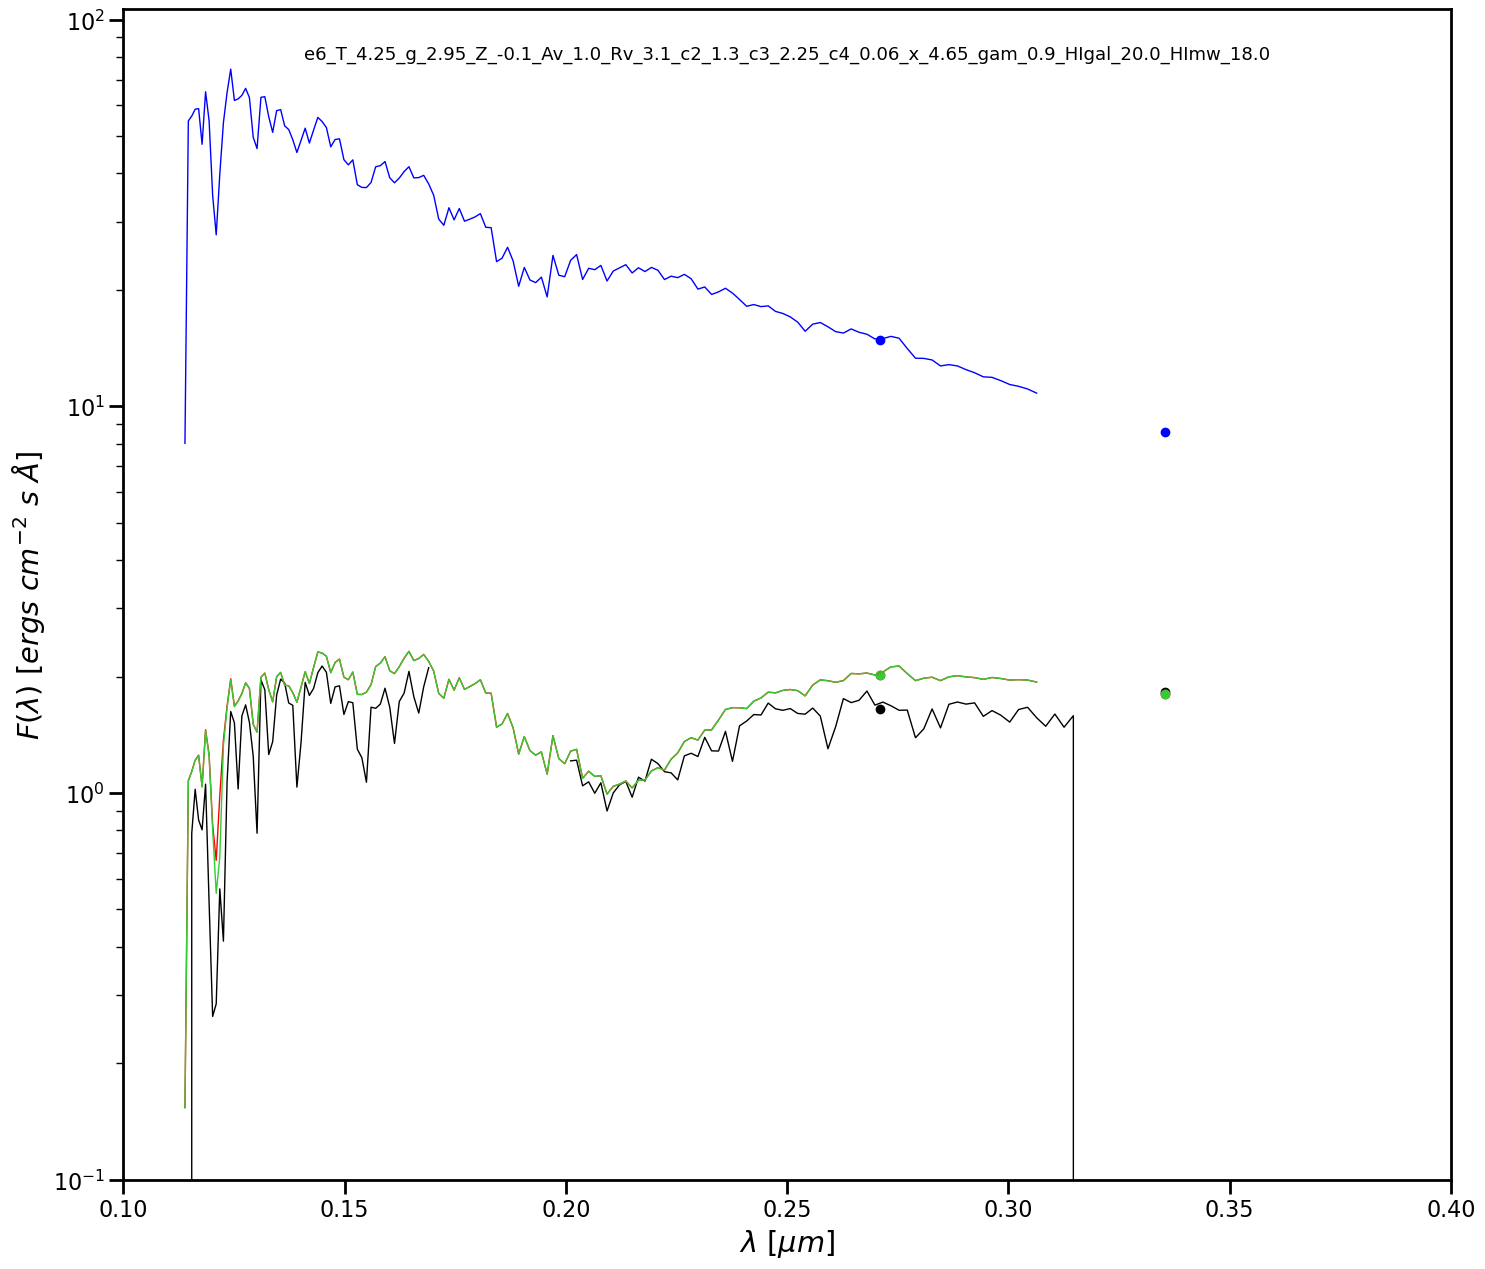

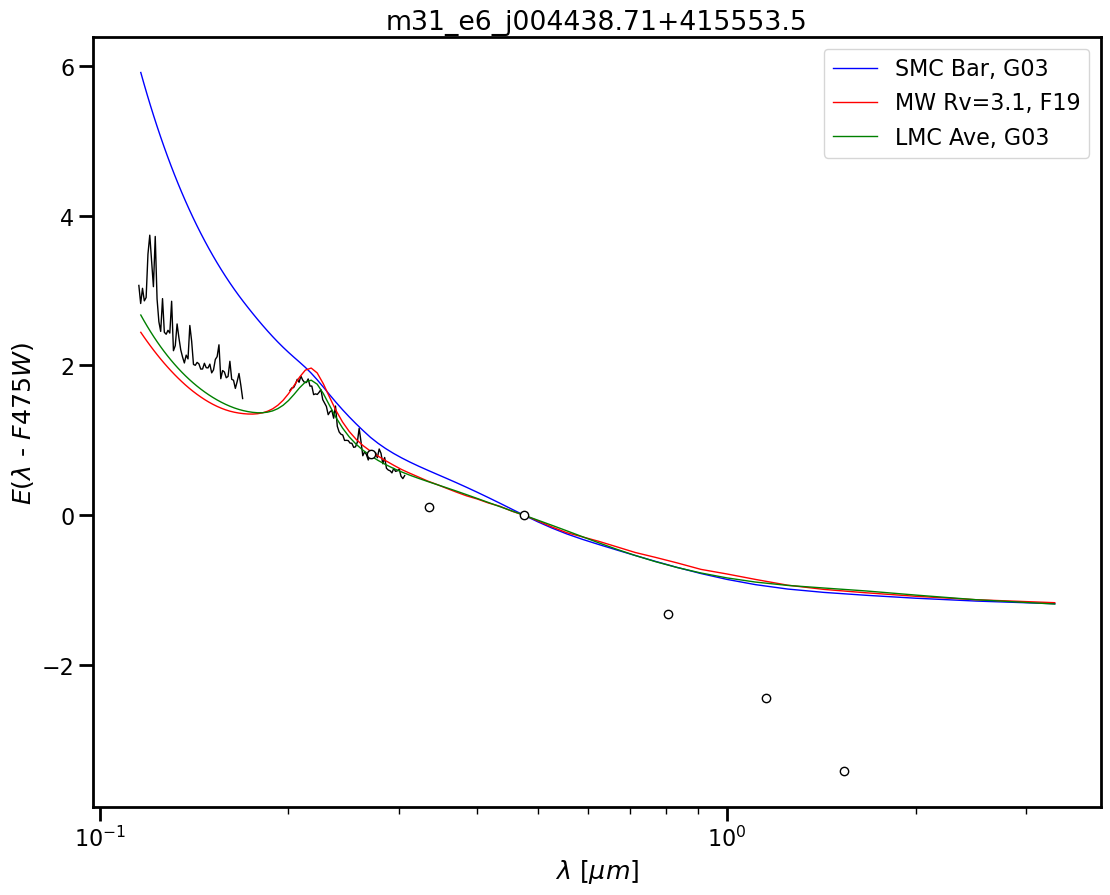

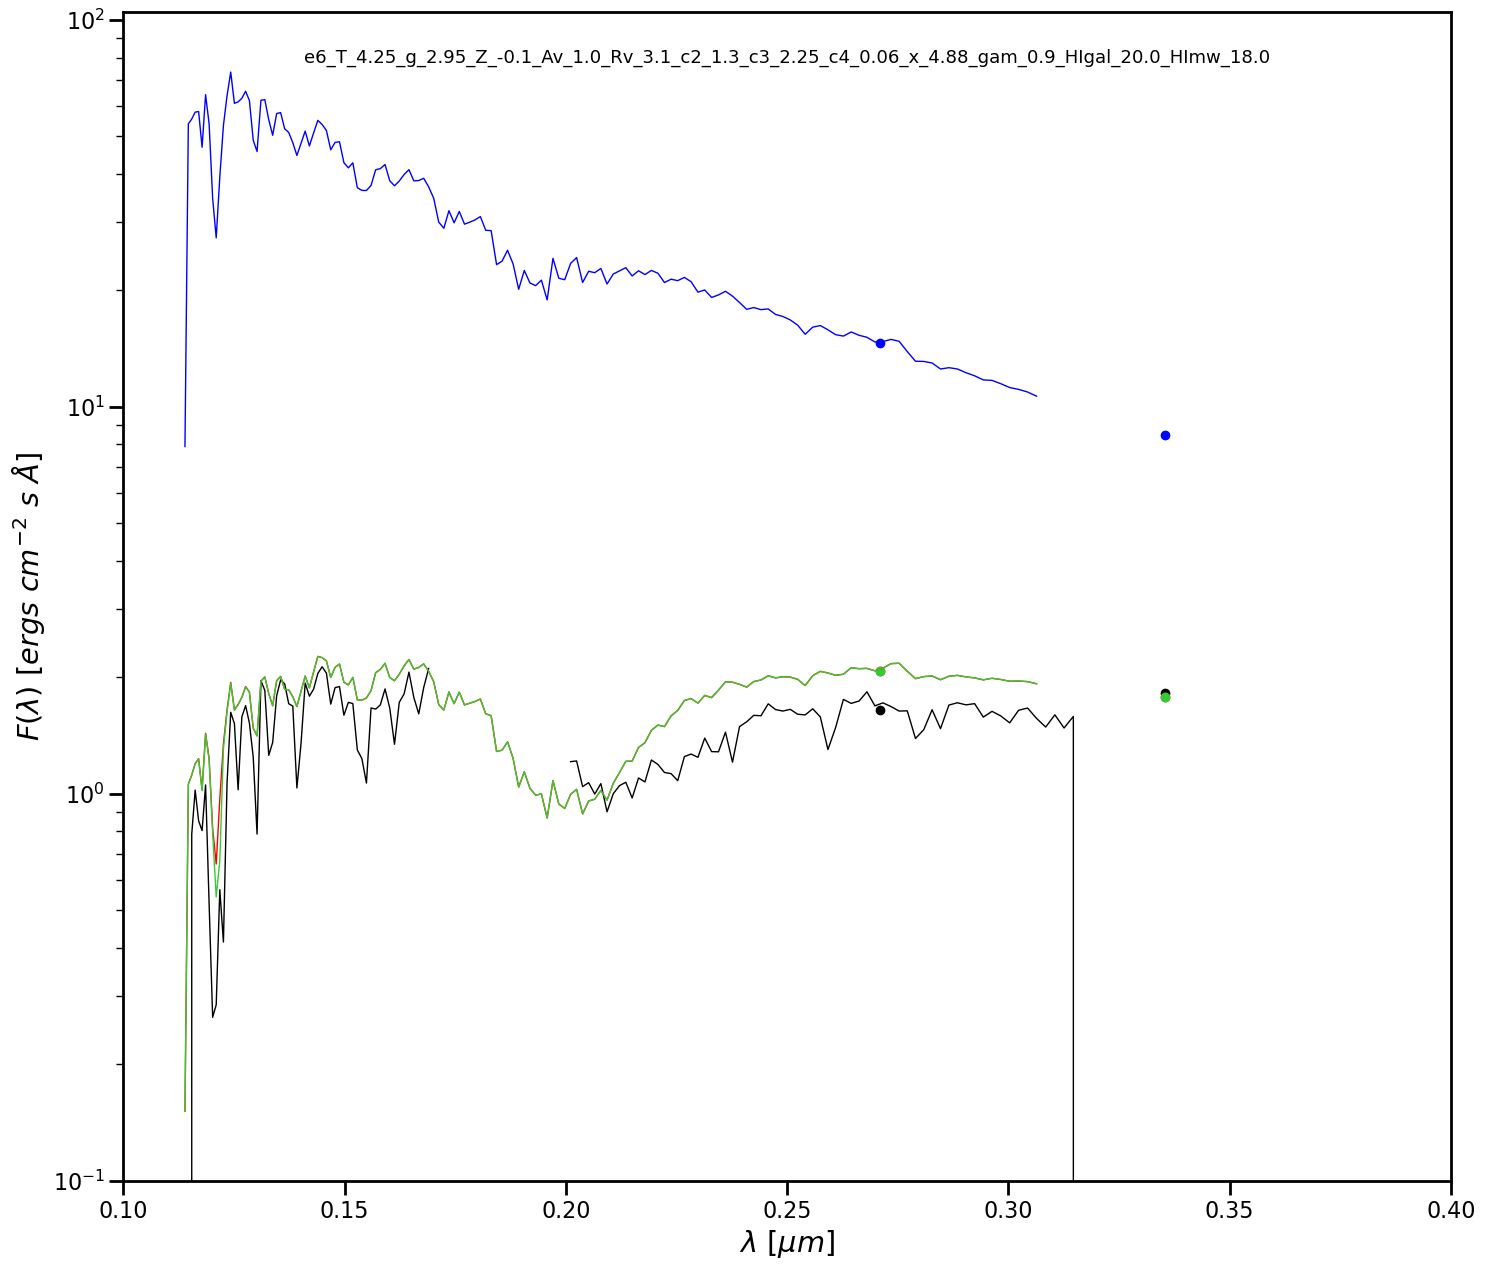

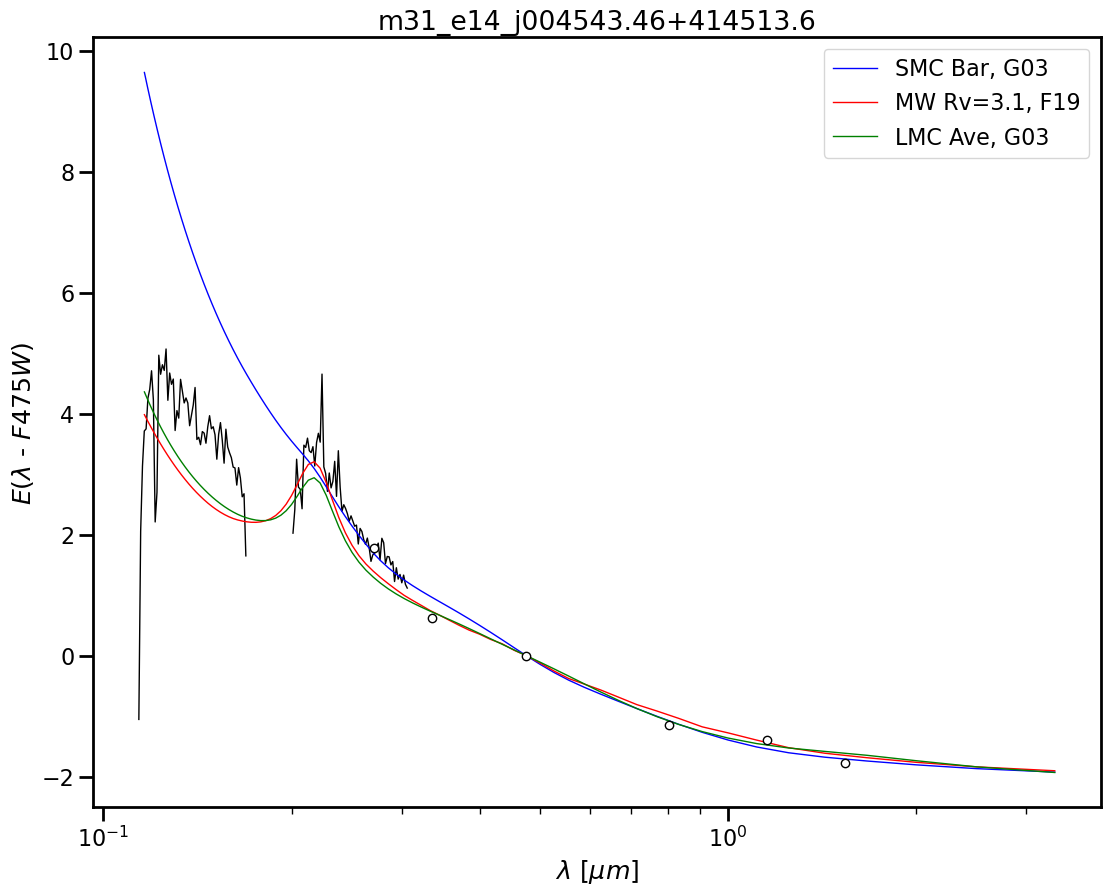

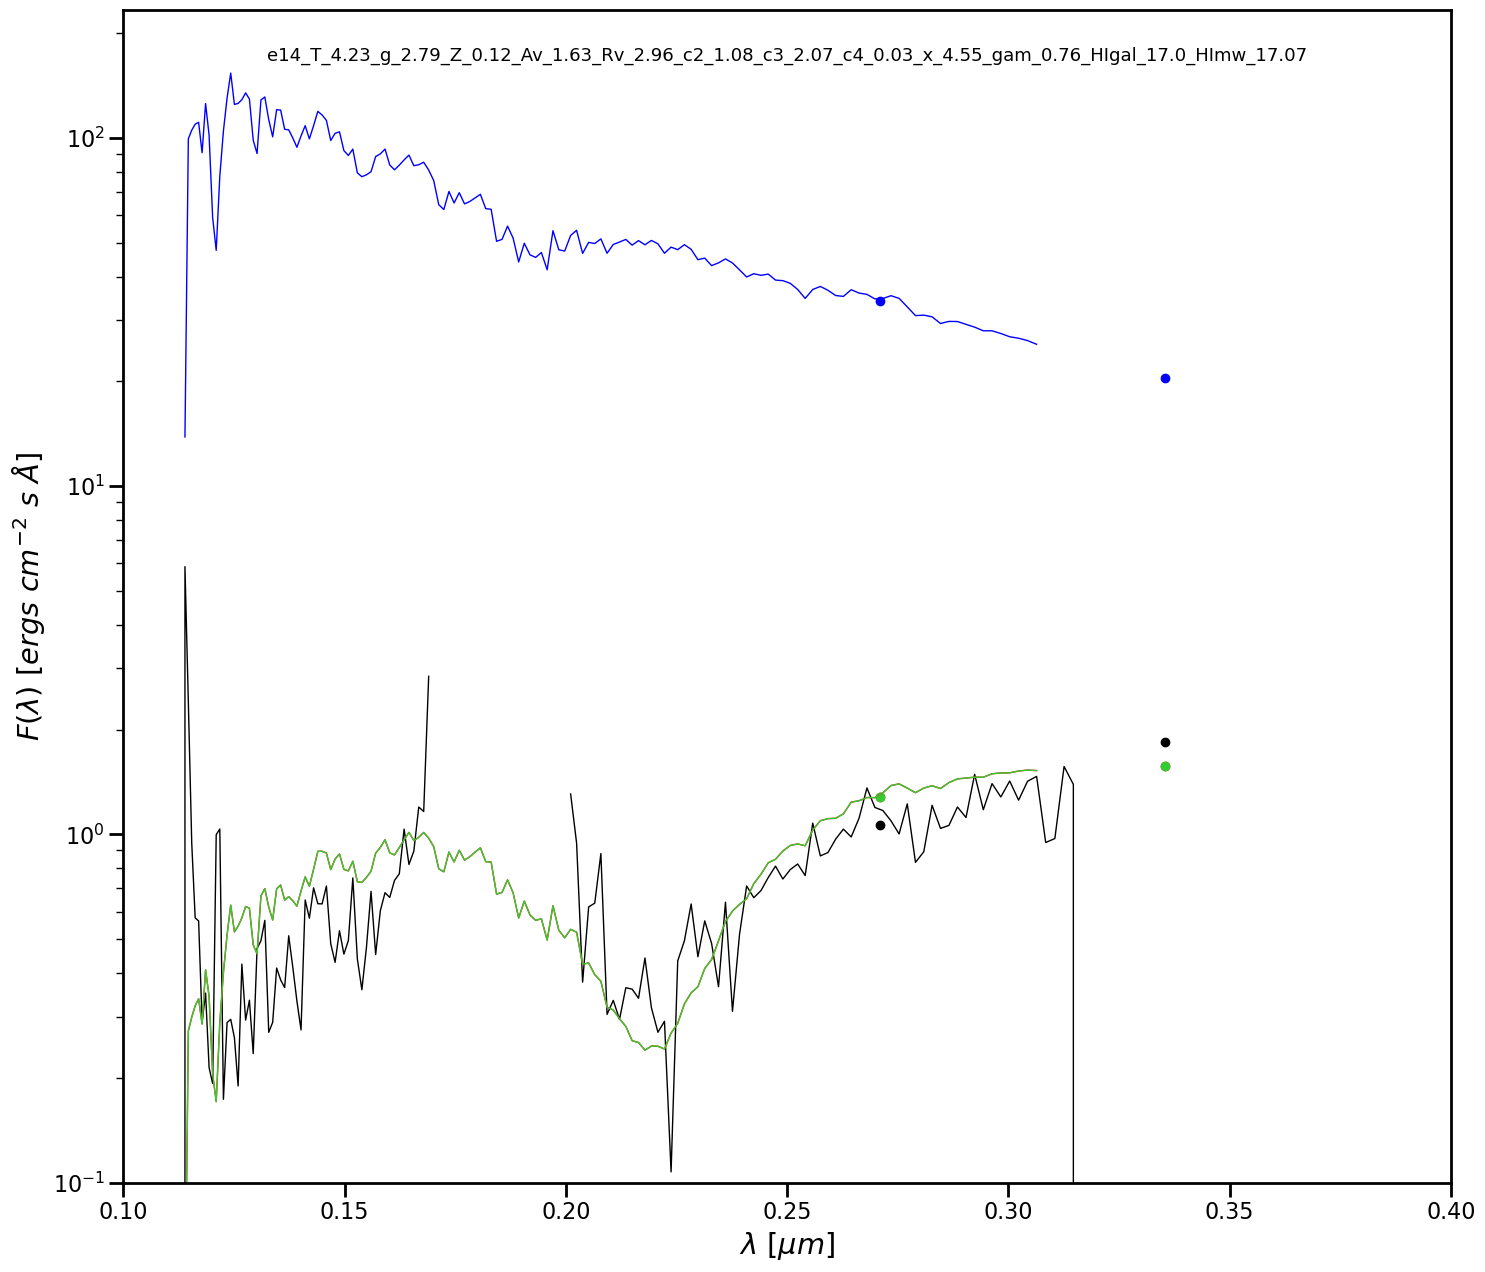

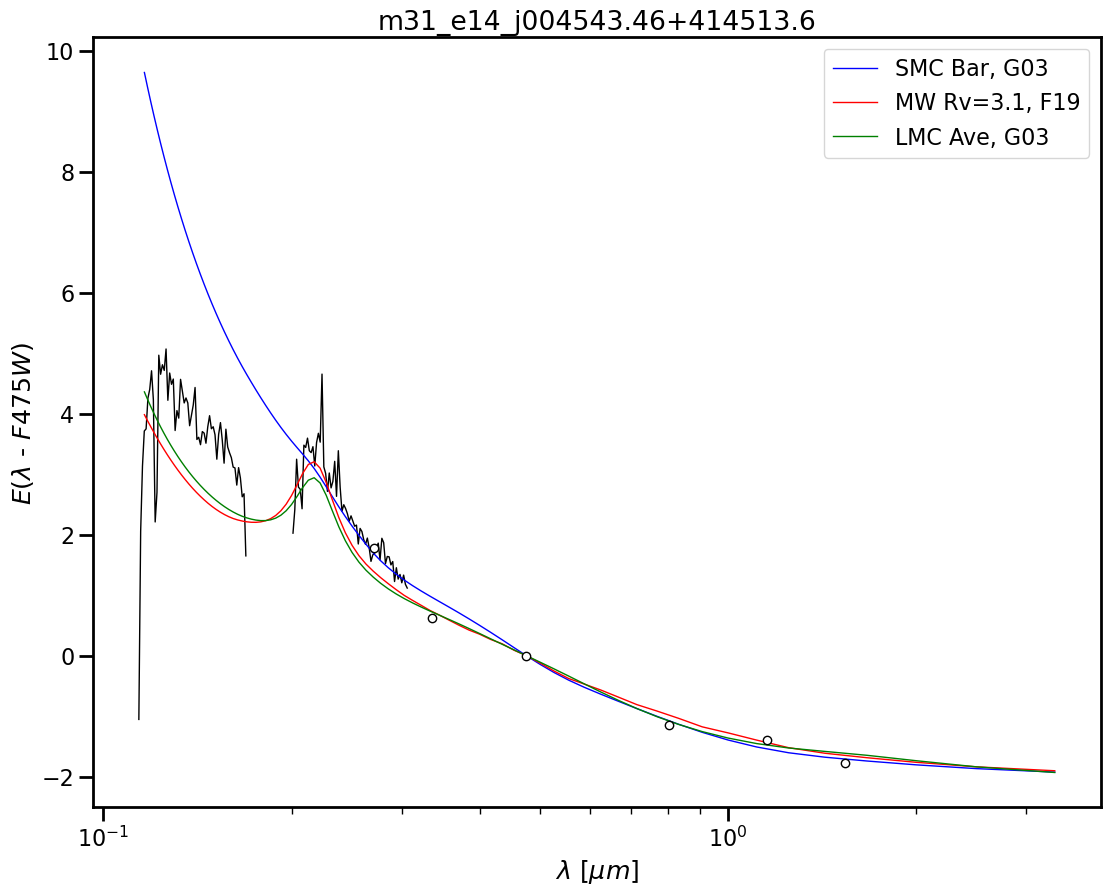

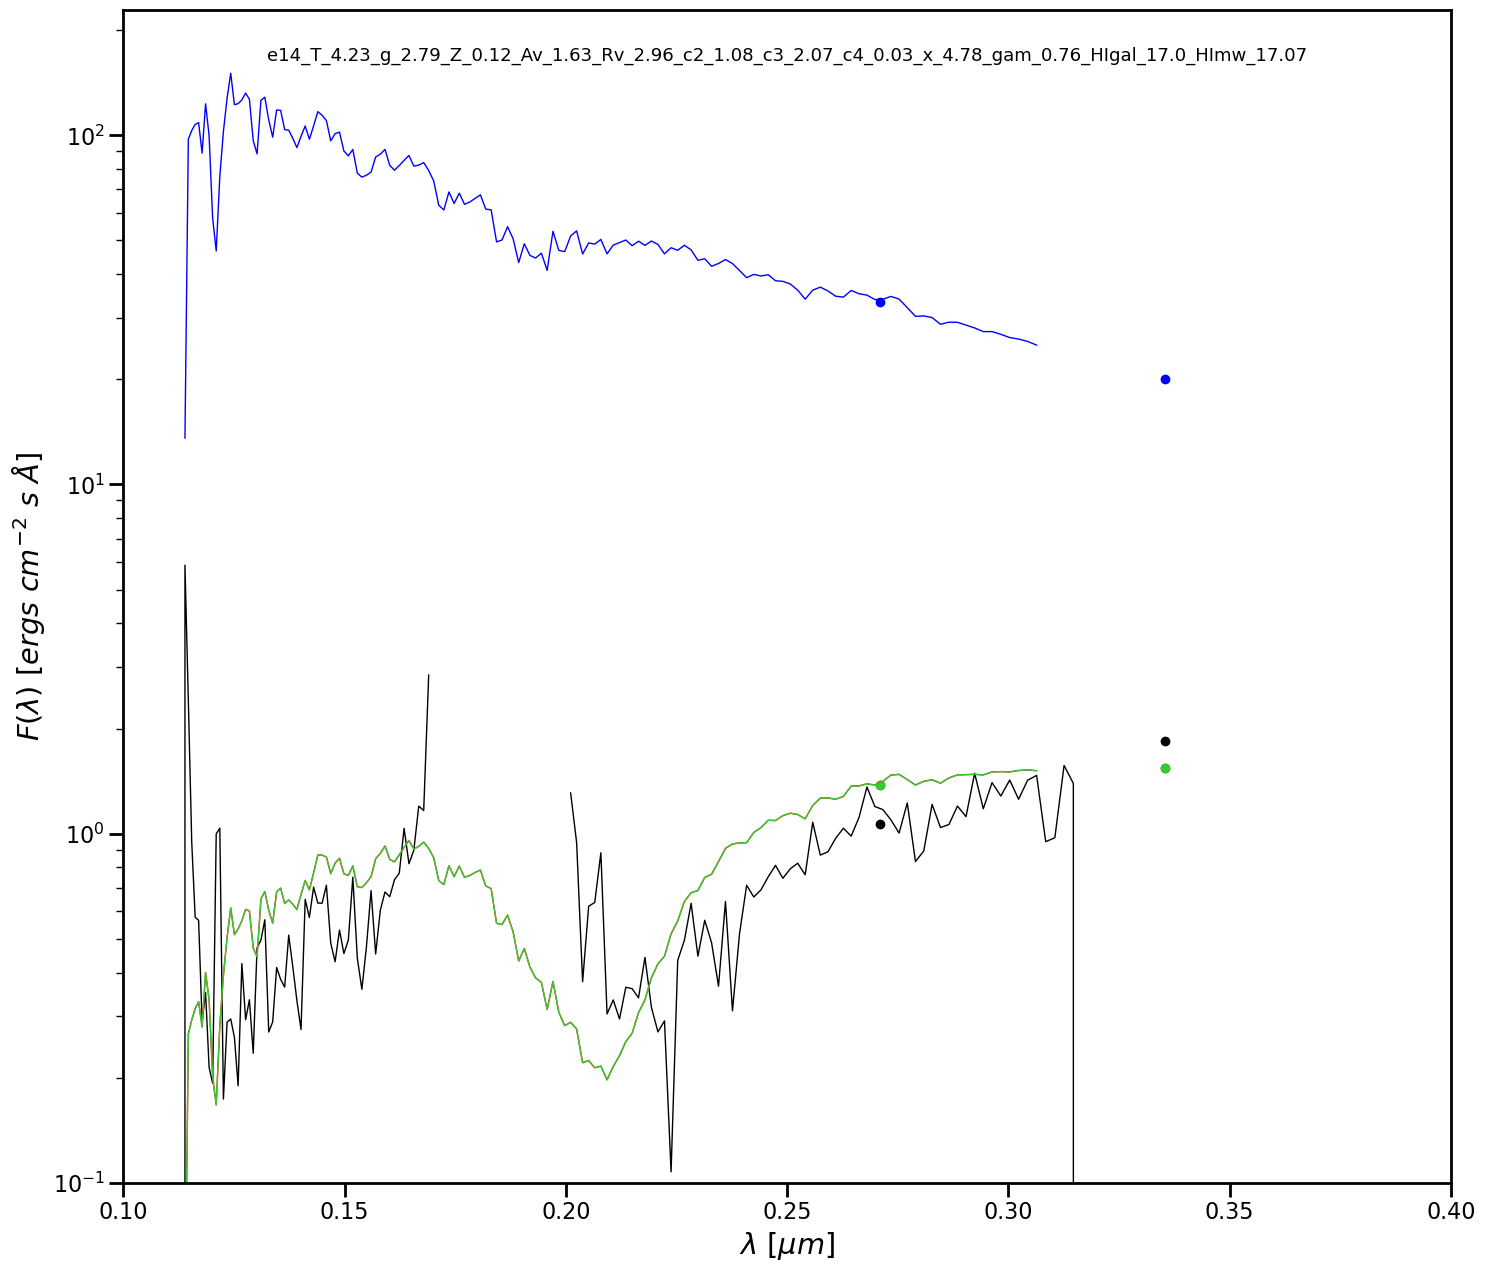

In [56]:
# Calculates all extinction curves
doall=True
singlevalued=True
save_ext_curve=True
plot_ext_curve=True

# If get_uncert is True, it will run the MCMC sampler
get_uncert = False
print('Galaxy:', gal_str)
excl_wls = [.17, .2]

if doall:
    for i, s in enumerate(m31_list):
        starname = m31_list[i]
        starstr = starname.split(gal_str)[1].split("_")[0]
        fstarname = f"{starname}.dat"

        # Read in star data
        reddened_star, band_names, data_names = get_red_star(fstarname, file_path, excl_wls=excl_wls)

        # Remove negative fluxes
        nvals = reddened_star.data["STIS"].fluxes < 0
        reddened_star.data["STIS"].npts[nvals] = 0

        # Rebin spectra
        reddened_star.data["STIS"].rebin_constres(rwaverange, gres)

        # Adjust spectra
        spec_adj = spec_corr(galaxy, starstr)
        reddened_star.data["STIS"].fluxes = (reddened_star.data["STIS"].fluxes.value * spec_adj) * (u.erg / ((u.cm ** 2) * u.s * u.angstrom))

        # old:
        # reddened_star.data["STIS"].npts = reddened_star.data["STIS"].fluxes.value - spec_adj

        # Set up parameter ranges, mostly relevant if testing initial values
        initial_grid, logtgrid, logggrid, logzgrid, \
        avgrid, rvgrid, \
        c2grid, c3grid, c4grid, \
        x0grid, gammagrid, \
        hi_galgrid, hi_mwgrid = setup_param_ranges(starname, starstr, small_vary=False)

        
        # 1. Plot model with initial guess
        # 2. Then plot model with improvement from optimizer
        # 3. (Separate step; below) Then plot model with improvement from MCMC sampler        

        do_calc(reddened_star,
                initial_grid, 
                singlevalued, 
                get_uncert, 
                save_ext_curve,
                plot_ext_curve)

### Plot FM parameters

In [54]:
print("galaxy", gal_str)
if 'm33' in gal_str:
    m31_list = ["m33_e1_j013334.26+303327", 
                 "m33_e2_j013339.52+304540",
                 "m33_e4_j013344.59+304436",  
                 "m33_e7_j012241.93+304728"]
elif 'm31' in gal_str:
    m31_list = [
        #"m31_e1_j004354.05+412626.0",
        "m31_e2_j004413.84+414903.9", "m31_e3_j004420.52+411751.1",
        "m31_e4_j004427.47+415150.0","m31_e5_j004431.66+413612.4",
        #"m31_e6_j004438.71+415553.5",
        "m31_e7_j004454.37+412823.9","m31_e8_j004511.82+415025.3","m31_e9_j004511.85+413712.9", 
        # "m31_e10_j004512.73+413726.4", # No STIS data, "m31_e11_j004535.40+414431.5", # No STIS data
        "m31_e12_j004539.00+415439.0","m31_e13_j004539.70+415054.8",
        "m31_e14_j004543.46+414513.6","m31_e15_j004546.81+415431.7",
            ]
# M31 FM90 params
# c2 = [1.182, 0.984, 1.259, 1.155, 0.842, 1.147, 0.665, 0.84, 1.06, 1.24, 1.36]
# c3 = [2.13, 1.212, 1.0975, 2.165, 1.37, 1.21, 1.88, 2.14, 2.31, 1.39, 1.89]
# c4 = [0.118, 0.117, 0.0242, 0.067, 0.019, 0.153, 0.241, 0.011, 0.01, 0.02, 0.05]
# x0 = [4.795, 4.627, 4.817, 4.724, 4.74, 4.7, 4.6, 4.78, 4.87, 4.88, 4.85]
# ebv = [0.333, 0.355, 0.3988, 0.386, 0.54, 0.43, 0.37, 0.48, 0.464, 0.53, 0.39]
# gamma [0.88, 0.6, 0.758, 0.944, 1.098, 0.677, 0.959, 0.862, 1.068, 0.604, 0.947]

    
    
# for i, star in enumerate(m31_list):
#     starstr = star.split(gal_str)[1].split("_")[0]
#     print("star", star)
#     print("starstr", starstr)

#     results_file = "params_dat/" + gal_str.split("_")[0] + "/" + starstr + "_fit_params.dat"

#     with open(results_file, 'r') as f:
#         x = [float(line.strip()) for line in lines if line]
#         print("x", x)
#         print("type x", type(x))
        
# #     with open(results_file, 'r') as f:
# #         lines = (line.strip() for line in f if line)
# #         print("lines", lines)
# #         x = [float(line) for line in lines]
# #         print("x", x)

#     resdata = np.fromfile(results_file, dtype="float", sep="\n")
#     print("resdata", resdata)
#     logt = [resdata[0]]
#     logg = [resdata[1]]
#     logz = [resdata[2]]
#     av = [resdata[3]]
#     rv = [resdata[4]]
#     c2 = [resdata[5]]
#     c3 = [resdata[6]]
#     c4 = [resdata[7]]
#     x0 = [resdata[8]]
#     gamma = [resdata[9]]
#     hi_gal = [resdata[10]]
#     hi_mwgrid = [resdata[11]]
#     hi_av = [resdata[12]]
#     hi_ebv = [resdata[13]]
    
#     print("star", star)
#     print("logt", logt)
#     print("logz", logz)

    #f = open("params_dat/" + gal_str.split("_")[0] + "/" + starstr + "_fit_params.dat", "r")
    
#     r = f.read()
#     for j in range(15):
#         print(j)
#         print(r[j])
    

# for k, val in enumerate(params_per):
#     f.read(
#         "{} {} {} {} # {}\n".format(
#            params_best[k], val[0], val[1], val[2], pnames_extra[k]
#         )
#     )

logt=[]; logtp50=[]; logtp1sig=[]; logtm1sig=[]
logg=[]; loggp50=[]; loggp1sig=[]; loggm1sig=[]
logz=[]; logzp50=[]; logzp1sig=[]; logzm1sig=[]
av=[]; avp50=[]; avp1sig=[]; avm1sig=[]
rv=[]; rvp50=[]; rvp1sig=[]; rvm1sig=[]
c2=[]; c2p50=[]; c2p1sig=[]; c2m1sig=[]
c3=[]; c3p50=[]; c3p1sig=[]; c3m1sig=[]
c4=[]; c4p50=[]; c4p1sig=[]; c4m1sig=[]
x0=[]; x0p50=[]; x0p1sig=[]; x0m1sig=[]
gamma=[]; gammap50=[]; gammap1sig=[]; gammam1sig=[]
higal=[]; higalp50=[]; higalp1sig=[]; higalm1sig=[]
himw=[]; himwp50=[]; himwp1sig=[]; himwm1sig=[]
p1=[];p2=[];p3=[];p4=[];p5=[];p6=[];p7=[];p8=[];p9=[];p10=[];p11=[];p12=[]

p = [p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12]

plt.figure(figsize=(20,15))

for i, star in enumerate(m31_list):
    starname = star
    starstr = starname.split(gal_str)[1].split("_")[0]
    results_file = "params_dat/" + gal_str.split("_")[0] + "/" + starstr + "_fit_params.dat"

    with open(results_file) as fin:
        data = (i for i in fin if not i.isspace())
#         print("data", data)
#         print(data[0])
        resdata = np.fromfile(results_file, dtype="float", sep="\n")
        j=0
        for row in data:
            p[j].append(row)
            print("row", row)
            print("type row", type(row))
            print("float(row[2])", float(row[2]))
            sig=(float(row[2]) - float(row[3]))/2
            print("sig", sig)
            j+=1
            if j < 7:
                row = next(data)

                
# plt.subplot(231)
# plt.subplot(232)
# plt.subplot(233)
# plt.subplot(234)
# plt.subplot(235)
# plt.subplot(236)

# plt.savefig(savefile_path + "fmparams/fm_1.png", bbox_inches='tight')

galaxy m31_
row 4.694151866692288 4.693642450493978 0.041914705021047105 0.00180619833925455 # logT

type row <class 'str'>
float(row[2]) 6.0
sig -1.5
row 0.09043416532084692 0.09095418484937859 0.0016587150419656999 0.021206892294348648 # logZ

type row <class 'str'>
float(row[2]) 0.0
sig -4.5
row 2.790973238918475 2.8129902531168383 0.02279568837659296 0.013486559222494865 # Rv

type row <class 'str'>
float(row[2]) 7.0
sig -1.0
row 2.1287680990476576 2.2380208483402697 0.08064768280370105 0.08539199842891021 # C3

type row <class 'str'>
float(row[2]) 1.0
sig -0.5
row 4.794502139223515 4.810343863197098 0.028429507455979497 0.013076391947438815 # x0

type row <class 'str'>
float(row[2]) 7.0
sig -1.0
row 17.001855226130626 17.30195360926112 0.4553675628288971 0.25469450433289964 # HI_gal

type row <class 'str'>


ValueError: could not convert string to float: '.'

<Figure size 1440x1080 with 0 Axes>

### Calc & save ext curve with new best fit params
#### (now fit_params = params; also params_best = params &  pnames_extra = pnames)

In [23]:
# intrinsic sed
modsed = modinfo_rb.stellar_sed(fit_params[0:3], velocity=velocity)

# dust_extinguished sed
ext_modsed = modinfo_rb.dust_extinguished_sed(fit_params[3:10], modsed)

# hi_abs sed
hi_ext_modsed = modinfo_rb.hi_abs_sed(
    fit_params[10:12], [velocity, 0.0], ext_modsed
)

# create a StarData object for the best fit SED
modsed_stardata = modinfo_rb.SED_to_StarData(modsed)

# create an extincion curve and save it
extdata = ExtData()
extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
col_info = {"av": fit_params[3], "rv": fit_params[4]}
extdata.save("extcurves/" + starstr + "_ext2.fits", column_info=col_info)

NameError: name 'fit_params' is not defined

### Plot new best-fit model spectra

In [21]:
def plot_new_bf_spectra(hi_ext_modsed, reddened_star):
    """
    """""
    norm_model = np.average(hi_ext_modsed["BAND"])
    norm_data = np.average(reddened_star.data["BAND"].fluxes)

    # plotting setup for easier to read plots
    fontsize = 16
    font = {"size": fontsize}
    mpl.rc("font", **font)
    mpl.rc("lines", linewidth=1)
    mpl.rc("axes", linewidth=2)
    mpl.rc("xtick.major", width=2)
    mpl.rc("xtick.minor", width=2)
    mpl.rc("ytick.major", width=2)
    mpl.rc("ytick.minor", width=2)

    # setup the plot
    fig, ax = plt.subplots(figsize=(13, 9.5))

    # plot the bands and all spectra for this star
    for cspec in modinfo.fluxes.keys():
        if cspec == "BAND":
            ptype = "o"
        else:
            ptype = "-"

        # ax.plot(reddened_star.data[cspec].waves,
        #        weights[cspec], 'k-')

        ax.plot(
            reddened_star.data[cspec].waves,
            reddened_star.data[cspec].fluxes / norm_data,
            "k" + ptype,
            label="data",
        )

        # print(reddened_star.data[cspec].waves)
        # print(modinfo.waves[cspec])

        ax.plot(
            modinfo.waves[cspec], modsed[cspec] / norm_model, "b" + ptype, label=cspec
        )
        ax.plot(
            modinfo.waves[cspec],
            ext_modsed[cspec] / norm_model,
            "r" + ptype,
            label=cspec,
        )
        ax.plot(
            modinfo.waves[cspec],
            hi_ext_modsed[cspec] / norm_model,
            "g" + ptype,
            label=cspec,
        )

    # finish configuring the plot
    ax.set_ylim(8e4 / norm_model, 6e9 / norm_model)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    ax.tick_params("both", length=10, width=2, which="major")
    ax.tick_params("both", length=5, width=1, which="minor")

    # ax.legend()

    # use the whitespace better
    # fig.tight_layout()
    plt.title(starname)
    plt.savefig(savefile_path + starstr + "_spectra2" + ".png")

NameError: name 'hi_ext_modsed' is not defined

### Plot new best-fit extinction curve

True


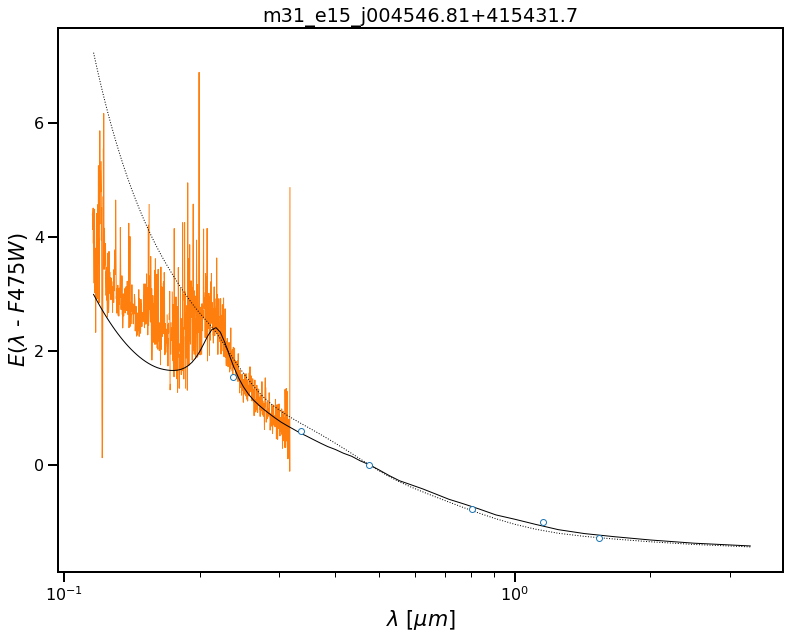

In [168]:
fig, ax = plt.subplots(figsize=(13, 10))

# convert from E(l-V) to A(l)/A(V)
print(extdata.type_rel_band != "V")
extdata.columns["AV"] = (params[3], 0.0)
# extdata.trans_elv_alav()

# def trans_elv_elvebv
extdata.plot(ax) #, alax=True)
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
#ax.set_ylim(0.0, 10.0)
# ax.set_ylabel(r"$A(\lambda)/A(V)$", fontsize=1.3 * fontsize)
ax.set_ylabel(fr"$E(\lambda$ - %s)" % relband_str, fontsize=1.3 * fontsize)
ax.tick_params("both", length=10, width=2, which="major")
ax.tick_params("both", length=5, width=1, which="minor")

# plot known exitnction curves
mod_x = np.arange(0.3, 8.7, 0.1) / u.micron
smcbar = G03_SMCBar()
# ax.plot(1.0 / mod_x, smcbar(mod_x), "k:")
Af475wAv = smcbar(0.475 * u.micron)
smcbar_el475w = (smcbar(mod_x) - Af475wAv) * params[3]
ax.plot(1.0 / mod_x, smcbar_el475w, "k:")

f19_rv31 = F19(Rv=3.1)
# ax.plot(1.0 / mod_x, f19_rv31(mod_x), "k-")
# ax.set_xlim(0, 7.5)
Af475wAv = f19_rv31(0.475 * u.micron)
f19_el475w = (f19_rv31(mod_x) - Af475wAv) * params[3]
ax.plot(1.0 / mod_x, f19_el475w, "k-")
plt.title(starname)
plt.savefig(savefile_path + starstr + "_extcurve2" + ".png")


### Plot new spectra function 

In [ ]:
def plot_spectra_with_mod(modinfo, hi_ext_modsed, reddened_star, modsed, ext_modsed, \
                          modsed_stardata, starstr, params, initial_grid):
    """
    """
    norm_model = np.average(hi_ext_modsed["BAND"])
    norm_data = np.average(reddened_star.data["BAND"].fluxes)

    # plotting setup for easier to read plots
    fontsize = 16
    font = {"size": fontsize}
    mpl.rc("font", **font)
    mpl.rc("lines", linewidth=1)
    mpl.rc("axes", linewidth=2)
    mpl.rc("xtick.major", width=2)
    mpl.rc("xtick.minor", width=2)
    mpl.rc("ytick.major", width=2)
    mpl.rc("ytick.minor", width=2)

    # setup the plot
    fig, ax = plt.subplots(figsize=(14, 12))

    # plot the bands and all spectra for this star
    for cspec in modinfo.fluxes.keys():
        if cspec == "BAND":
            ptype = "o"
        else:
            ptype = "-"

        # ax.plot(reddened_star.data[cspec].waves, weights[cspec], 'k-')

        # Observations
        ax.plot(
            reddened_star.data[cspec].waves,
            reddened_star.data[cspec].fluxes / norm_data,
            "k" + ptype,
            label="data",
        )

        # Intrinsic SED
#         print("test rebinned intrinsic wavelengths", modinfo.waves[cspec])
#         print("test rebinned intrinsic fluxes", modsed[cspec] / norm_model)
        ax.plot(
            modinfo.waves[cspec], 
            modsed[cspec] / norm_model, 
            "b" + ptype, label=cspec
        )
        
        # dust_extinguished sed
        ax.plot(
            modinfo.waves[cspec],
            ext_modsed[cspec] / norm_model,
            "r" + ptype,
            label=cspec,
        )
        
        # h(i) abs sed
        ax.plot(
            modinfo.waves[cspec],
            hi_ext_modsed[cspec] / norm_model,
            "g" + ptype,
            label=cspec,
        )

    # finish configuring the plot
#     ax.set_ylim(8e4 / norm_model, 6e9 / norm_model)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    ax.tick_params("both", length=10, width=2, which="major")
    ax.tick_params("both", length=5, width=1, which="minor")

    # ax.legend()

    # use the whitespace better
    fig.tight_layout()
    
    # pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4",
    #"x0","gamma","HI_gal","HI_mw"]
#     print("params in plot_spectra_with_mod()", params)
    logt_round = np.around(params[0], decimals=2)
    logg_round = np.around(params[1], decimals=2)
    logz_round = np.around(params[2], decimals=2)
    av_round = np.around(params[3], decimals=2)
    rv_round = np.around(params[4], decimals=2)
    c2_round = np.around(params[5], decimals=2)
    c3_round = np.around(params[6], decimals=2)
    c4_round = np.around(params[7], decimals=2)
    x0_round = np.around(params[8], decimals=2)
    g_round = np.around(params[9], decimals=2)
    higal_round = np.around(params[10], decimals=2)
    himw_round = np.around(params[11], decimals=2)
    print("Fig params are log(T)=%s, log(g)=%s, Av=%s" % (params[0], params[1], params[3]))
    
    # Generate a name to record the star and its parameters
    param_combo_str = "_T_" + str(logt_round)  + "_g_" + str(logg_round) + \
                "_Z_" + str(logz_round) + \
                "_Av_"  + str(av_round) + "_Rv_" + str(rv_round) + "_c2_" + \
                str(c2_round) + "_c3_" + str(c3_round) + "_c4_" + str(c4_round) + "_x_" + \
                str(x0_round) + "_gam_" + str(g_round) + \
                "_HIgal_" + str(higal_round) + "_HImw_" + str(himw_round)
    print("star", starstr)
    
#     ax.set_title(starstr + param_combo_str, y=0.95, fontsize=13)
    
    # Title with initial value for initial pos
    param_combo_str_init = "_T_" + str(initial_grid[0][0])  + "_g_" + str(initial_grid[1][0]) + \
                "_Z_" + str(initial_grid[2][0]) + \
                "_Av_"  + str(initial_grid[3][0]) + "_Rv_" + str(initial_grid[4][0]) + "_c2_" + \
                str(initial_grid[5][0]) + "_c3_" + str(initial_grid[6][0]) + "_c4_" + str(initial_grid[7][0]) + "_x_" + \
                str(initial_grid[8][0]) + "_gam_" + str(initial_grid[9][0]) + \
                "_HIgal_" + str(initial_grid[10][0]) + "_HImw_" + str(initial_grid[11][0])

    # Set title to updated initial position, param_combo_str
    ax.set_title(starstr + param_combo_str, y=0.95, fontsize=15)
    
    if 'e6' in fstarname:
        ax.set_xlim(0.1, 1)
#     elif 'e2' in fstarname:
    ax.set_ylim(0.01, 250)

#     plt.savefig(savefile_path + "spectra_w_mod/" + starstr + "_rb_" +  str(gres) + "_res.png")
    plt.savefig(savefile_path + "starting_positions_retry/" + str(starstr) + "/" + starstr + "_rb_" +  \
                str(gres) + param_combo_str + ".png")
    print("Saved spectra w mod")

## Plot ext curve param results (put at end)

In [118]:
m31_results = [
    #"m31_e1_j004354.05+412626.0", # Prob. w sorting by UV slope; bad fit, no uncert. results
    "m31_e2_j004413.84+414903.9",
#     "m31_e3_j004420.52+411751.1",
#     "m31_e4_j004427.47+415150.0",
#     "m31_e5_j004431.66+413612.4",
#     "m31_e6_j004438.71+415553.5", # bad fit, no uncert. results
#     "m31_e7_j004454.37+412823.9",
#     "m31_e8_j004511.82+415025.3",
#     "m31_e9_j004511.85+413712.9", # some problem with walkers
#     "m31_e12_j004539.00+415439.0",
#     "m31_e13_j004539.70+415054.8",
#     "m31_e14_j004543.46+414513.6", # Prob. w sorting by UV slope
#     "m31_e15_j004546.81+415431.7",
]

# best fit, p50, p50 + 1sig, p50 - 1sig
logt=[]; logtp50=[]; logtp1sig=[]; logtm1sig=[]
logg=[]; loggp50=[]; loggp1sig=[]; loggm1sig=[]
logz=[]; logzp50=[]; logzp1sig=[]; logzm1sig=[]
av=[]; avp50=[]; avp1sig=[]; avm1sig=[]
rv=[]; rvp50=[]; rvp1sig=[]; rvm1sig=[]
c2=[]; c2p50=[]; c2p1sig=[]; c2m1sig=[]
c3=[]; c3p50=[]; c3p1sig=[]; c3m1sig=[]
c4=[]; c4p50=[]; c4p1sig=[]; c4m1sig=[]
x0=[]; x0p50=[]; x0p1sig=[]; x0m1sig=[]
gamma=[]; gammap50=[]; gammap1sig=[]; gammam1sig=[]
higal=[]; higalp50=[]; higalp1sig=[]; higalm1sig=[]
himw=[]; himwp50=[]; himwp1sig=[]; himwm1sig=[]
p1=[];p2=[];p3=[];p4=[];p5=[];p6=[];p7=[];p8=[];p9=[];p10=[];p11=[];p12=[]

p = [p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12]
# for k, val in enumerate(params_per):
#     f.write(
#         "{} {} {} {} # {}\n".format(
#            params_best[k], val[0], val[1], val[2], pnames_extra[k]
#         )
#     )
#f.write("# best fit, p50, +unc, -unc\n")

# Read in fit values
for i, star in enumerate(m31_results):
    starname = star
    starstr = starname.split(gal_str)[1].split("_")[0]
    results_file = "params_dat/" + starstr + "_fit_params.dat"

    with open(results_file) as fin:
        data = (i for i in fin if not i.isspace())
        print("data", data)
        j=0
        for row in data:
            p[j].append(row)
            print(row)
            j+=1
            if j < 7:
                row = next(data)

    print(p)
#     
#     ipdata = np.fromfile(results_file, dtype="float", sep="\n")
#     print(ipdata)
#     logg.append([ipdata[1]])
#     logz.append([ipdata[2]])
#     av.append([ipdata[3]])
#     rv.append([ipdata[4]])
#     c2.append([ipdata[5]])
#     c3.append([ipdata[6]])
#     c4.append([ipdata[7]])
#     x0.append([ipdata[8]])
#     gamma.append([ipdata[9]])
#     HI_gal.append([ipdata[10]])
#     HI_mw.append([ipdata[11]])

data <generator object <genexpr> at 0x7fe5d4b1e450>
4.740334323488035 4.720856487354006 0.013529512828514889 0.0624197943401521 # logT

0.12215133428859155 0.09814391806892488 0.024976488195594365 0.015346901345937775 # logZ

2.7882822368557316 2.785400311391983 0.013110457907309137 0.08745751605367857 # Rv

1.3706544827143778 1.4854677806800254 0.4242025430187235 0.09459494574376204 # C3

4.706031216614668 4.703716160298124 0.009524804283738142 0.02232121690192912 # x0

17.214366297626526 17.74036796872021 4.1065032768429255 0.65625008504637 # HI_gal

0.3339587616706861 0.3228745786632307 0.011338121862540296 0.010367198172903713 # E(B-V)

1.759287121735708e+17 6.018784288322455e+17 8.346946299972925e+21 4.69694982431252e+17 # N(HI)/A(V)

4.905389031064722e+17 1.675897632975754e+18 2.2585297291353086e+22 1.3070545041231828e+18 # N(HI)/E(B-V)
[['4.740334323488035 4.720856487354006 0.013529512828514889 0.0624197943401521 # logT\n'], ['0.12215133428859155 0.09814391806892488 0.0249764881